## 1.0 Kaggle Submission Notebook Version

## 2.1 Import Libraries

In [1]:
import gc  # Garbage collection interface
# Provides an interface for interacting with the garbage collector, which can help manage memory usage.
from glob import glob  # Pattern matching in filenames
# Allows the use of Unix shell-style wildcards to find all the pathnames matching a specified pattern.
from pathlib import Path  # Object-oriented filesystem paths
# Provides an object-oriented way of dealing with filesystem paths, offering methods and properties for file handling.
from datetime import datetime  # Manipulating dates and times
# Supplies classes for manipulating dates and times, allowing you to perform date arithmetic and formatting.
import numpy as np  # Numerical computations
# A library for numerical operations, providing support for arrays, matrices, and many mathematical functions.
import pandas as pd  # Data manipulation and analysis
# A powerful library for data manipulation and analysis, offering data structures like DataFrame and Series for handling tabular and time series data.
import polars as pl  # High-performance DataFrame library
# An alternative DataFrame library designed for performance and parallelism, suitable for large datasets.
import matplotlib.pyplot as plt  # Plotting interface
# A plotting library for creating static, interactive, and animated visualizations in Python.
import seaborn as sns  # Statistical data visualization
# A data visualization library built on top of Matplotlib, providing a high-level interface for drawing attractive statistical graphics.
from sklearn.model_selection import StratifiedGroupKFold  # Data splitting and cross-validation
# A class for splitting data into training and validation sets while preserving the percentage of samples for each class, considering groups.
from sklearn.base import BaseEstimator, ClassifierMixin  # Base classes for custom estimators
# Base classes that facilitate the creation of custom estimators by providing a standard interface.
import lightgbm as lgb  # Gradient boosting framework
# A fast, distributed, high-performance gradient boosting framework for machine learning, particularly effective for large datasets.
from sklearn.metrics import roc_auc_score  # Model evaluation metrics
# A function to compute the Area Under the Receiver Operating Characteristic Curve (ROC AUC), which is a measure of model performance.
from scipy.stats import linregress  # Probability distributions and statistical functions
# Provides functions for performing linear regression, as well as other statistical analyses and probability distributions.
import warnings  # Issuing and controlling warnings
# A module for issuing warning messages and controlling their visibility and behavior.
warnings.simplefilter(action='ignore', category=FutureWarning)  # Suppress specific warnings
# Configures the warnings module to ignore FutureWarning messages, which are often raised by libraries like Pandas for upcoming changes.
from sklearn.calibration import CalibratedClassifierCV
# A function to calibrate the predicted probabilities of a base classifier to improve the accuracy of probability estimates.
from sklearn.calibration import calibration_curve
# A function to compute calibration curves, which compare predicted probabilities to actual outcomes to assess the accuracy of probability predictions.

from datetime import datetime
# get the current date time for further use


## 2.2 Data Preprocessing and Cleaning Pipeline

In [2]:
# pre-processing functions
def drop_high_null_columns(df, threshold=0.5):
    # Calculate the percentage of null values for each column
    null_percentages = df.isnull().mean()
    # Identify columns where the percentage of null values exceeds the threshold
    cols_to_drop = null_percentages[null_percentages > threshold].index.tolist()
    # Drop the identified columns from the DataFrame
    df = df.drop(columns=cols_to_drop)
    return df

class Pipeline:
    @staticmethod
    def set_table_dtypes(df):  # Set data types for DataFrame columns
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int32))  # Cast to integer
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))  # Cast to date
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))  # Cast to float
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))  # Cast to string
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))  # Cast to date

        return df
    
    @staticmethod
    def handle_dates(df):  # Handle date columns in DataFrame
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))  # Subtract reference date
                df = df.with_columns(pl.col(col).dt.total_days())  # Convert to total days
                df = df.with_columns(pl.col(col).cast(pl.Float32))  # Cast to float
                
        df = df.drop("date_decision", "MONTH")  # Drop specific columns

        return df
    
    @staticmethod
    def filter_cols(df):  # Filter columns in DataFrame
        # List of attributes to exclude
        excluded_attributes = [
            "addres_district_368M", "addres_role_871L", "addres_zip_823M",
            "amtinstpaidbefduel24m_4187115A", "annualeffectiverate_199L", "annuity_853A",
            "applicationcnt_361L", "applications30d_658L", "applicationscnt_1086L",
            "applicationscnt_464L", "applicationscnt_629L", "applicationscnt_867L",
            "approvaldate_319D", "assignmentdate_238D", "assignmentdate_4527235D",
            "assignmentdate_4955616D", "bankacctype_710L", "birth_259D", "birthdate_574D",
            "birthdate_87D", "byoccupationinc_3656910L", "cardtype_51L", "childnum_21L",
            "classificationofcontr_1114M", "classificationofcontr_13M", "classificationofcontr_400M",
            "clientscnt_100L", "clientscnt_1022L", "clientscnt_1071L", "clientscnt_1130L",
            "clientscnt_136L", "clientscnt_157L", "clientscnt_257L", "clientscnt_304L",
            "clientscnt_360L", "clientscnt_493L", "clientscnt_533L", "clientscnt_887L",
            "clientscnt_946L", "clientscnt12m_3712952L", "clientscnt3m_3712950L",
            "clientscnt6m_3712949L", "cntpmts24_3658933L", "collater_typofvalofguarant_298M",
            "collater_typofvalofguarant_407M", "collaterals_typeofguarante_359M",
            "collaterals_typeofguarante_669M", "contaddr_district_15M", "contaddr_matchlist_1032L",
            "contaddr_smempladdr_334L", "contaddr_zipcode_807M", "contractdate_551D",
            "contractenddate_991D", "contractmaturitydate_151D", "contractst_964M",
            "contractsum_5085717L", "contracttype_653M", "conts_role_79M", "conts_type_509L",
            "creationdate_885D", "credlmt_228A", "credlmt_230A", "credor_3940957M", "credtype_322L",
            "credtype_587L", "dateactivated_425D", "datefirstoffer_1144D", "datelastinstal40dpd_247D",
            "datelastunpaid_3546854D", "dateofcredend_289D", "dateofcredend_353D", "dateofcredstart_181D",
            "dateofcredstart_739D", "dateofrealrepmt_138D", "deductiondate_4917603D", "description_351M",
            "description_5085714M", "disbursementtype_67L", "district_544M", "dpdmaxdatemonth_804T",
            "dpdmaxdatemonth_89T", "dpdmaxdateyear_596T", "dpdmaxdateyear_742T", "dpdmaxdateyear_896T",
            "dtlastpmt_581D", "dtlastpmtallstes_3545839D", "dtlastpmtallstes_4499206D", "education_1103M",
            "education_1138M", "education_88M", "education_927M", "eir_270L", "empl_employedfrom_271D",
            "empladdr_district_926M", "empladdr_zipcode_114M", "employedfrom_700D", "employername_160M",
            "empls_employedfrom_796D", "empls_employer_name_740M", "familystate_447L", "familystate_726L",
            "financialinstitution_382M", "financialinstitution_591M", "firstclxcampaign_1125D",
            "firstdatedue_489D", "firstnonzeroinstldate_307D", "fourthquarter_440L", "gender_992L",
            "housetype_905L", "housingtype_772L", "incometype_1044T", "inittransactioncode_186L",
            "inittransactioncode_279L", "isbidproduct_1095L", "isbidproduct_390L", "isbidproductrequest_292L",
            "isdebitcard_527L", "isdebitcard_729L", "language1_981M", "last180dayturnover_1134A",
            "last30dayturnover_651A", "lastactivateddate_801D", "lastapplicationdate_877D",
            "lastapprcommoditycat_1041M", "lastapprcommoditytypec_5251766M", "lastapprdate_640D",
            "lastcancelreason_561M", "lastdelinqdate_224D", "lastrejectcommoditycat_161M",
            "lastrejectcommodtypec_5251769M", "lastrejectdate_50D", "lastrejectreason_759M",
            "lastrejectreasonclient_4145040M", "lastrepayingdate_696D", "lastupdate_1112D",
            "lastupdate_260D", "lastupdate_388D", "maritalst_385M", "maritalst_703L", "maritalst_893M",
            "maxdpdinstldate_3546855D", "mobilephncnt_593L", "name_4527232M", "name_4917606M",
            "numberofoverdueinstlmaxdat_148D", "numberofoverdueinstlmaxdat_641D", "openingdate_313D",
            "openingdate_857D", "overdueamountmax2date_1002D", "overdueamountmax2date_1142D",
            "overdueamountmaxdatemonth_284T", "overdueamountmaxdatemonth_365T", "overdueamountmaxdatemonth_494T",
            "overdueamountmaxdateyear_2T", "overdueamountmaxdateyear_432T", "overdueamountmaxdateyear_994T",
            "paytype_783L", "paytype1st_925L", "payvacationpostpone_4187118D", "periodicityofpmts_1102L",
            "periodicityofpmts_837L", "personindex_1023L", "persontype_1072L", "persontype_792"
        ]

        df = df.drop(excluded_attributes, errors='ignore')  # Drop excluded attributes

        # Preprocess the DataFrame
        df = drop_high_null_columns(df)  # Drop columns with high null values
        # df = drop_high_cardinality_columns(df)

        # Count the number of columns with null values
        null_columns = df.isnull().sum()
        null_columns = null_columns[null_columns > 0]
        num_null_columns = len(null_columns)

        # Print the number of columns with null values
        print(f"Number of columns with null values: {num_null_columns}")

        # Impute missing values
        for col in df.columns:
            if df[col].dtype == 'object' or df[col].dtype == 'category':
                if not df[col].mode().empty:
                    mode = df[col].mode().iloc[0]  # Calculate the mode
                    df[col].fillna(mode, inplace=True)  # Fill null values with the mode
                else:
                    print(f"No mode available for column '{col}'. Skipping imputation for this column.")
            elif df[col].dtype in ['int64', 'float64']:
                skewness = df[col].skew()  # Check the skewness of the column
                if skewness < -1 or skewness > 1:  # Highly skewed
                    median = df[col].median()
                    df[col].fillna(median, inplace=True)  # Fill null values with the median
                else:  # Normal or slightly skewed
                    mean = df[col].mean()
                    df[col].fillna(mean, inplace=True)  # Fill null values with the mean
                   
        # Print the number of rows and columns
        print(f"Number of rows and columns: {df.shape}")
        return df

## 2.3 Feature Engineering and Data Enrichment

In [3]:
def calculate_age_from_year(year):
    if year is None:
        return None
    current_year = datetime.today().year
    return current_year - year

def combine_education_levels(edu1, edu2):
    if edu1 is None and edu2 is None:
        return None
    elif edu1 is None:
        return edu2
    elif edu2 is None:
        return edu1
    else:
        return max(edu1, edu2)

def feature_eng(df_base, depth_0, depth_1, depth_2):
    # Add basic date features
    df_base = df_base.with_columns(
        pl.col("date_decision").dt.month().alias("month_decision"),
        pl.col("date_decision").dt.weekday().alias("weekday_decision"),
    )
    
    # Join additional dataframes
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    # Feature engineering: Sum of credit limits if they exist
    credit_limit_cols = ["credlmt_1052A", "credlmt_3940954A", "credlmt_935A"]
    if all(col_name in df_base.columns for col_name in credit_limit_cols):
        df_base = df_base.with_columns(
            (pl.col(credit_limit_cols).sum()).alias("total_credit_limit")
        )
    
    # Feature engineering: Deposit Ratio
    deposit_incoming_col = "amtdepositincoming_4809444A"
    deposit_outgoing_col = "amtdepositoutgoing_4809442A"
    
    if deposit_incoming_col in df_base.columns and deposit_outgoing_col in df_base.columns:
        df_base = df_base.with_columns(
            (pl.col(deposit_incoming_col) / pl.col(deposit_outgoing_col)).alias("deposit_ratio")
        )
    
    # Feature engineering: Date of birth related features (calculating age only)
    date_of_birth_cols = ["dateofbirth_337D", "dateofbirth_342D"]
    
    for col in date_of_birth_cols:
        if col in df_base.columns:
            df_base = df_base.with_columns(
                pl.col(col).cast(pl.Date).dt.year().apply(calculate_age_from_year, return_dtype=pl.Int64).alias(f"{col}_age")
            )
    
    # Feature engineering: Combine credit bureau queries
    query_cols = ["days120_123L", "days180_256L", "days30_165L", "days360_512L", "days90_310L"]
    
    if all(col in df_base.columns for col in query_cols):
        df_base = df_base.with_columns(
            sum([pl.col(col) for col in query_cols]).alias("total_queries")
        )
    
    # Feature engineering: Aggregate installment payment percentages
    early_payment_col = "pctinstlsallpaidearl3d_427L"
    late_payment_cols = [
        "pctinstlsallpaidlat10d_839L",
        "pctinstlsallpaidlate1d_3546856L",
        "pctinstlsallpaidlate4d_3546849L",
        "pctinstlsallpaidlate6d_3546844L"
    ]
    
    if early_payment_col in df_base.columns:
        df_base = df_base.with_columns(
            pl.col(early_payment_col).alias("total_early_payments")
        )
    
    if all(col in df_base.columns for col in late_payment_cols):
        df_base = df_base.with_columns(
            sum([pl.col(col) for col in late_payment_cols]).alias("total_late_payments")
        )
    
    # Feature engineering: Combine education levels
    edu1_col = "education_88M"
    edu2_col = "education_927M"
    
    if edu1_col in df_base.columns and edu2_col in df_base.columns:
        df_base = df_base.with_columns(
            pl.struct([pl.col(edu1_col), pl.col(edu2_col)]).apply(lambda row: combine_education_levels(row[edu1_col], row[edu2_col]), return_dtype=pl.Utf8).alias("combined_education")
        )
    
    # Handle dates if necessary
    df_base = df_base.pipe(Pipeline.handle_dates)
    
    # Check if the total_credit_limit feature is included
    if "total_credit_limit" in df_base.columns:
        print("total_credit_limit feature is included.")
    else:
        print("total_credit_limit feature is not included.")
        
    # Check if the deposit_ratio feature is included
    if "deposit_ratio" in df_base.columns:
        print("deposit_ratio feature is included.")
    else:
        print("deposit_ratio feature is not included.")
        
    # Check if the date of birth age features are included
    for col in date_of_birth_cols:
        if f"{col}_age" in df_base.columns:
            print(f"{col}_age feature is included.")
        else:
            print(f"{col}_age feature is not included.")
    
    # Check if the credit bureau queries feature is included
    if "total_queries" in df_base.columns:
        print("total_queries feature is included.")
    else:
        print("total_queries feature is not included.")
        
    # Check if the installment payment percentage features are included
    if "total_early_payments" in df_base.columns:
        print("total_early_payments feature is included.")
    else:
        print("total_early_payments feature is not included.")
    
    if "total_late_payments" in df_base.columns:
        print("total_late_payments feature is included.")
    else:
        print("total_late_payments feature is not included.")
        
    # Check if the combined education feature is included
    if "combined_education" in df_base.columns:
        print("combined_education feature is included.")
    else:
        print("combined_education feature is not included.")
    return df_base


## 2.4 Feature Aggregation for Enhanced Data Representation

In [4]:
class Aggregator:
    @staticmethod
    def num_expr(df):
        # Identify columns where the column name ends with 'P' or 'A'
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        
        # Create a list of expressions to calculate the maximum value for these columns
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def date_expr(df):
        # Identify columns where the column name ends with 'D'
        cols = [col for col in df.columns if col[-1] in ("D",)]
        
        # Create a list of expressions to calculate the maximum value for these columns
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def str_expr(df):
        # Identify columns where the column name ends with 'M'
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        # Create a list of expressions to calculate the maximum value for these columns
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def other_expr(df):
        # Identify columns where the column name ends with 'T' or 'L'
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        # Create a list of expressions to calculate the maximum value for these columns
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max
    
    @staticmethod
    def count_expr(df):
        # Identify columns that contain 'num_group' in their name
        cols = [col for col in df.columns if "num_group" in col]
        
        # Create a list of expressions to calculate the maximum value for these columns
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def get_exprs(df):
        # Combine all expressions from different categories (numerical, date, string, other, and count)
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

## 2.5 Function: to_pandas

In [5]:
def to_pandas(df_data, cat_cols=None):
    # Convert the input DataFrame to a pandas DataFrame
    df_data = df_data.to_pandas()
    
    # If cat_cols is not provided, identify all columns with object dtype
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    # Convert the identified categorical columns to the 'category' dtype
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    # Return the converted DataFrame and the list of categorical columns
    return df_data, cat_cols


## 2.6 File reading and Feature Engineering

In [6]:
def read_file(path, depth=None):
    # Read a Parquet file into a DataFrame
    df = pl.read_parquet(path)
    
    # Apply data type transformations using the Pipeline class
    df = df.pipe(Pipeline.set_table_dtypes)
    
    # If depth is 1 or 2, group by 'case_id' and aggregate using the expressions from the Aggregator class
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

def read_files(regex_path, depth=None):
    # Initialize an empty list to hold chunks of DataFrames
    chunks = []
    
    # Iterate over each file path that matches the given regex pattern
    for path in glob(str(regex_path)):
        # Read each Parquet file into a DataFrame
        df = pl.read_parquet(path)
        
        # Apply data type transformations using the Pipeline class
        df = df.pipe(Pipeline.set_table_dtypes)
        
        # If depth is 1 or 2, group by 'case_id' and aggregate using the expressions from the Aggregator class
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        
        # Append the processed DataFrame to the chunks list
        chunks.append(df)
    
    # Concatenate all DataFrames in the chunks list into a single DataFrame
    df = pl.concat(chunks, how="vertical_relaxed")
    
    # Ensure uniqueness by keeping only unique rows based on 'case_id'
    df = df.unique(subset=["case_id"])

    return df

    
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")
TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
    ]
}


df_train = feature_eng(**data_store)
print("train data shape:\t", df_train.shape)

data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
    ]
}

df_test = feature_eng(**data_store)
print("test data shape:\t", df_test.shape)

C:\Users\Darren Chang\AppData\Local\Temp\ipykernel_28484\481191131.py:50: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col(col).cast(pl.Date).dt.year().apply(calculate_age_from_year, return_dtype=pl.Int64).alias(f"{col}_age")
C:\Users\Darren Chang\AppData\Local\Temp\ipykernel_28484\481191131.py:50: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col(col).cast(pl.Date).dt.year().apply(calculate_age_from_year, return_dtype=pl.Int64).alias(f"{col}_age")


total_credit_limit feature is not included.
deposit_ratio feature is not included.
dateofbirth_337D_age feature is included.
dateofbirth_342D_age feature is included.
total_queries feature is included.
total_early_payments feature is included.
total_late_payments feature is included.
combined_education feature is not included.
train data shape:	 (1526659, 477)
total_credit_limit feature is not included.
deposit_ratio feature is not included.
dateofbirth_337D_age feature is included.
dateofbirth_342D_age feature is included.
total_queries feature is included.
total_early_payments feature is included.
total_late_payments feature is included.
combined_education feature is not included.
test data shape:	 (10, 476)


C:\Users\Darren Chang\AppData\Local\Temp\ipykernel_28484\481191131.py:50: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col(col).cast(pl.Date).dt.year().apply(calculate_age_from_year, return_dtype=pl.Int64).alias(f"{col}_age")
C:\Users\Darren Chang\AppData\Local\Temp\ipykernel_28484\481191131.py:50: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col(col).cast(pl.Date).dt.year().apply(calculate_age_from_year, return_dtype=pl.Int64).alias(f"{col}_age")


## 2.7 Efficient Dataframe Creation for Train and Test Sets

In [7]:
# Convert train data to pandas and filter
df_train, cat_cols = to_pandas(df_train)
df_train_final = df_train.pipe(Pipeline.filter_cols)

# Convert test data to pandas and filter
df_test, cat_cols = to_pandas(df_test, cat_cols)
df_test_final = df_test.pipe(Pipeline.filter_cols)


# Print the number of columns left
print("Number of columns left before filtering:", len(df_train_final.columns))
print("Number of columns left before filtering:", len(df_test_final.columns))


# Ensure that both train and test data have the same columns except for the target attribute
common_columns = list(set(df_train_final.columns).intersection(set(df_test_final.columns)))

# Add specific columns to the common columns list if they are not already present
columns_to_keep = ['case_id', 'WEEK_NUM', 'month_decision', 'weekday_decision']
for col in columns_to_keep:
    if col not in common_columns:
        common_columns.append(col)

# Preserve the original order of columns in df_train_final
common_columns = [col for col in df_train_final.columns if col in common_columns]

# Add 'target' column to train data
df_train_final = df_train_final[common_columns + ['target']]

# Filter test data to include only common columns
df_test_final = df_test_final[common_columns]

# Print the number of columns left
print("Number of columns left after filtering:", len(df_train_final.columns))
print("Number of columns left after filtering:", len(df_test_final.columns))

Number of columns with null values: 209
Number of rows and columns: (1526659, 278)
Number of columns with null values: 106
Number of rows and columns: (10, 203)
Number of columns left before filtering: 278
Number of columns left before filtering: 203
Number of columns left after filtering: 177
Number of columns left after filtering: 176


## 2.8 Remove the unused memory

In [8]:
del data_store
gc.collect()

0

# 3. Exploratory Data Analysis

## 3.1 Exploring Null Values after Data Cleaning

In [9]:
# Count the number of columns with null values
null_columns = df_train_final.isnull().sum()
null_columns = null_columns[null_columns > 0]
num_null_columns = len(null_columns)
# Print the number of columns with null values
print(f"Number of columns with null values for train dataset: {num_null_columns}")

# Count the number of columns with null values
null_columns = df_test_final.isnull().sum()
null_columns = null_columns[null_columns > 0]
num_null_columns = len(null_columns)
# Print the number of columns with null values
print(f"Number of columns with null values for test dataset: {num_null_columns}")

Number of columns with null values for train dataset: 5
Number of columns with null values for test dataset: 4


## 3.2 Boxplots

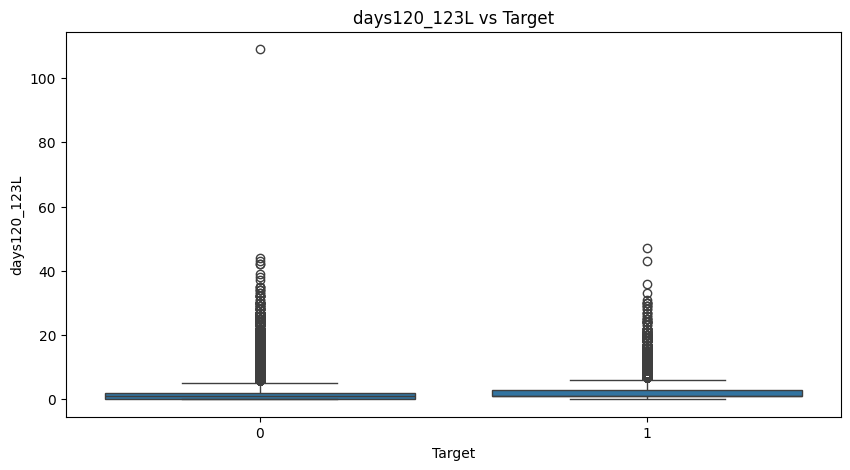

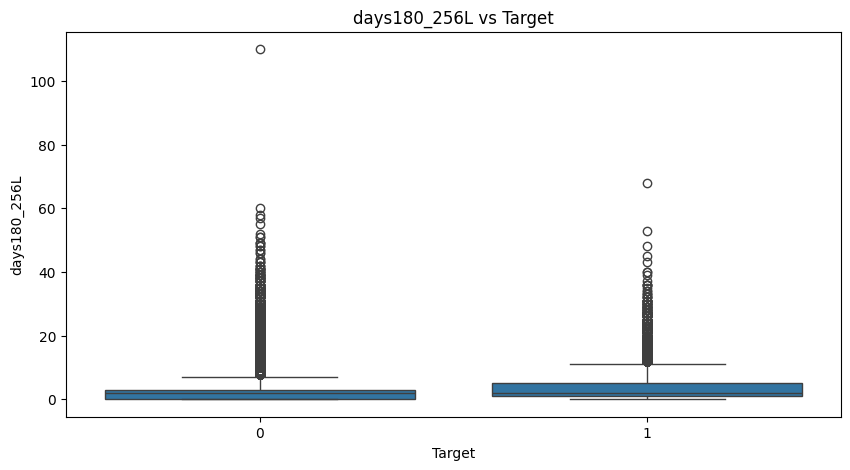

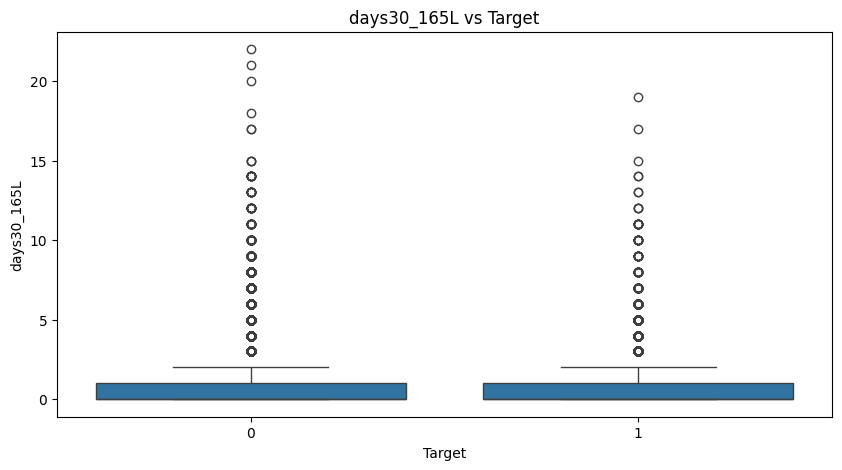

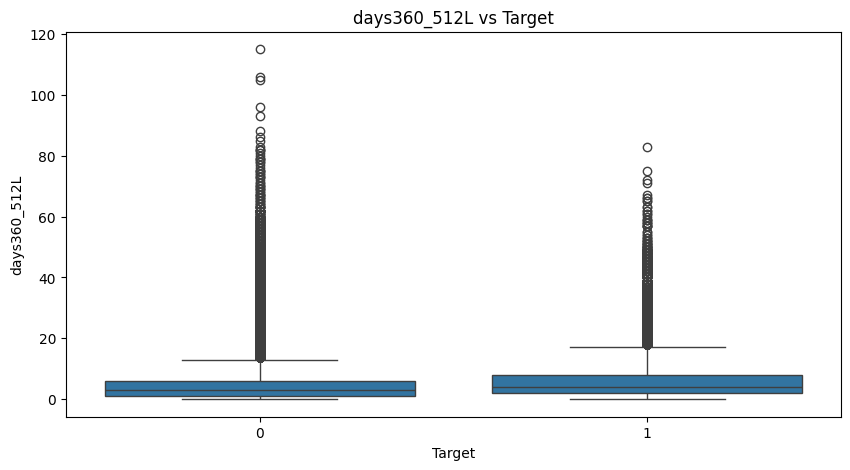

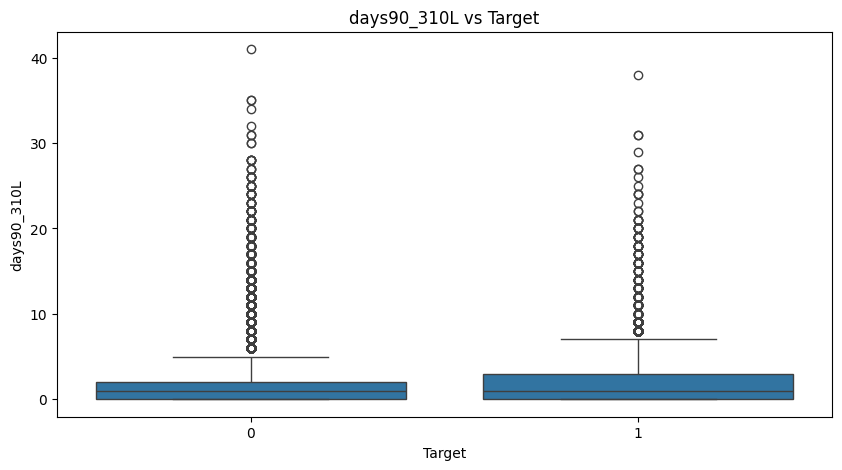

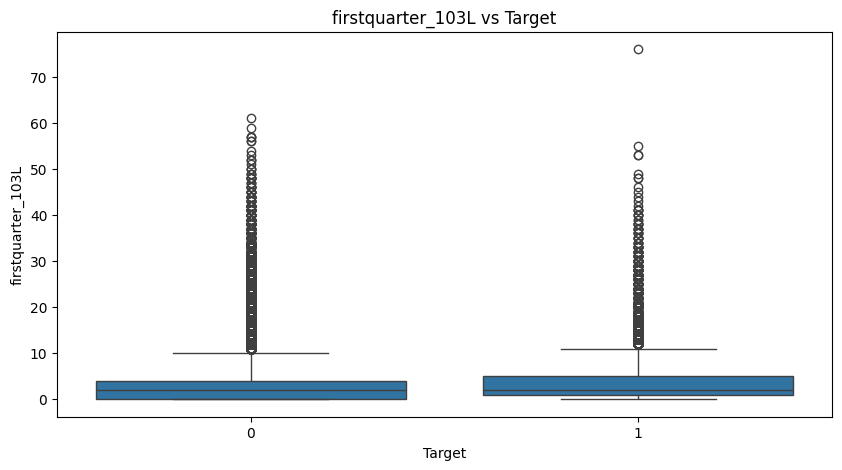

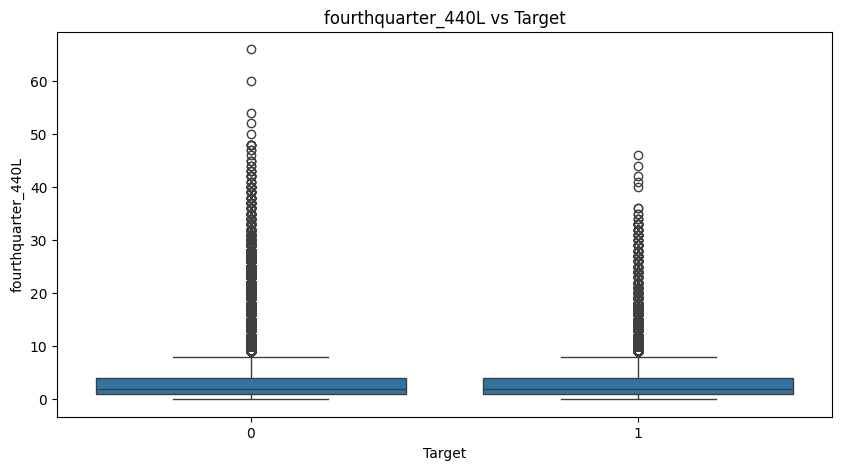

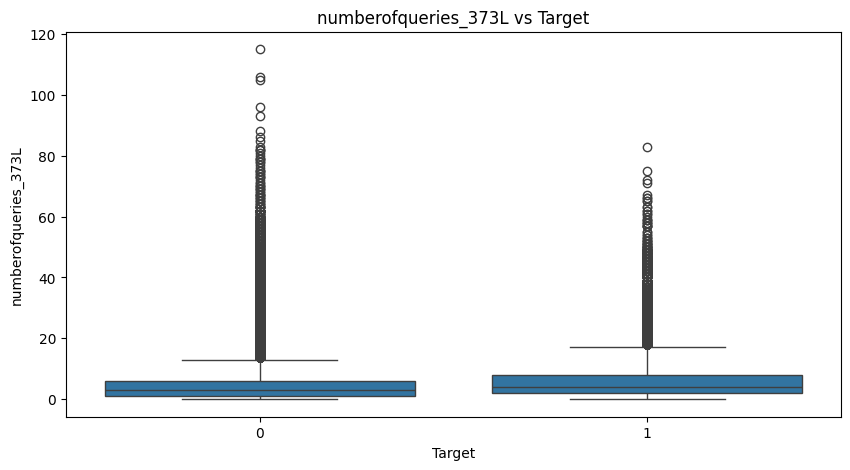

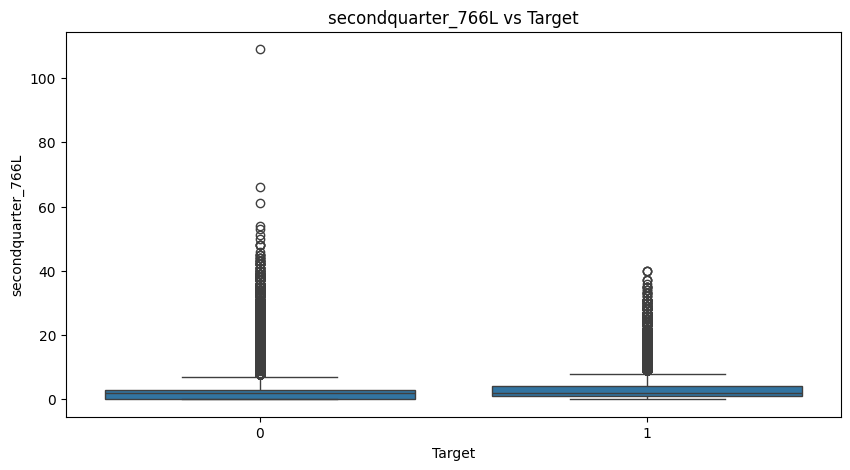

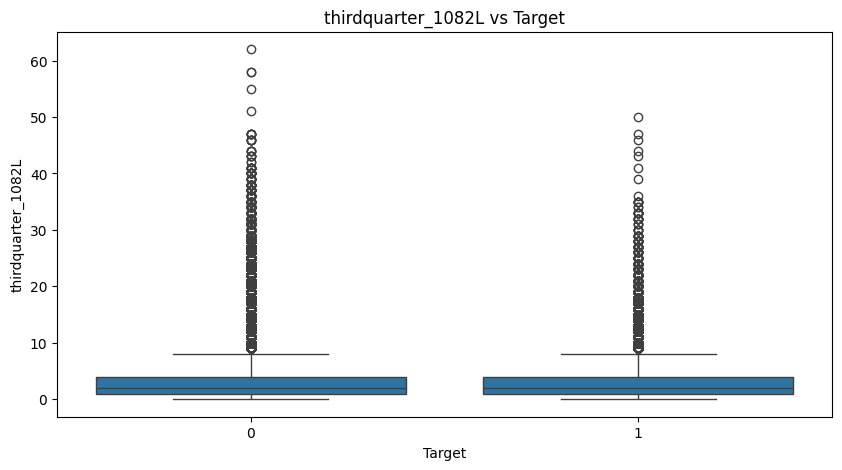

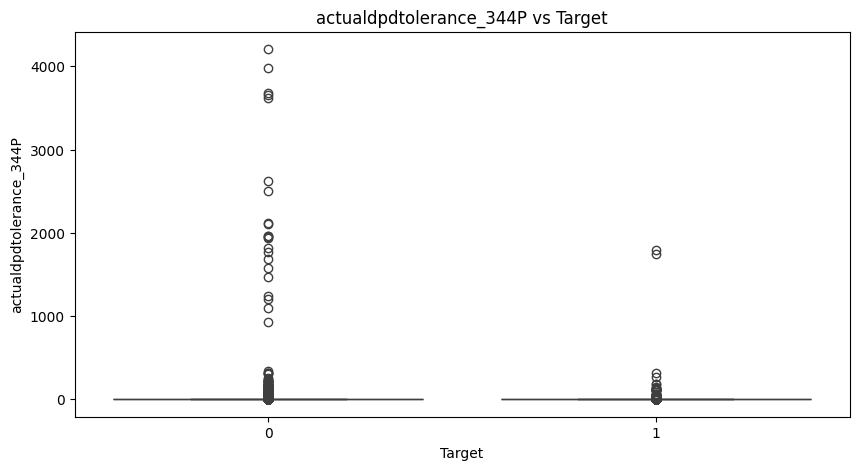

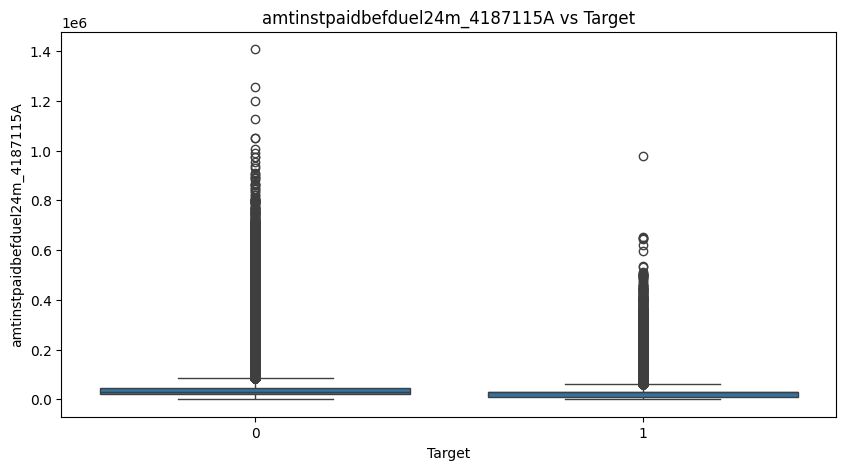

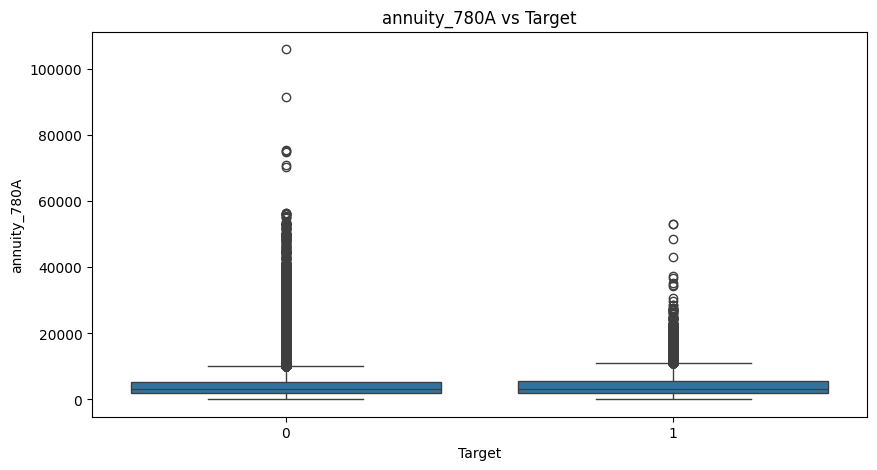

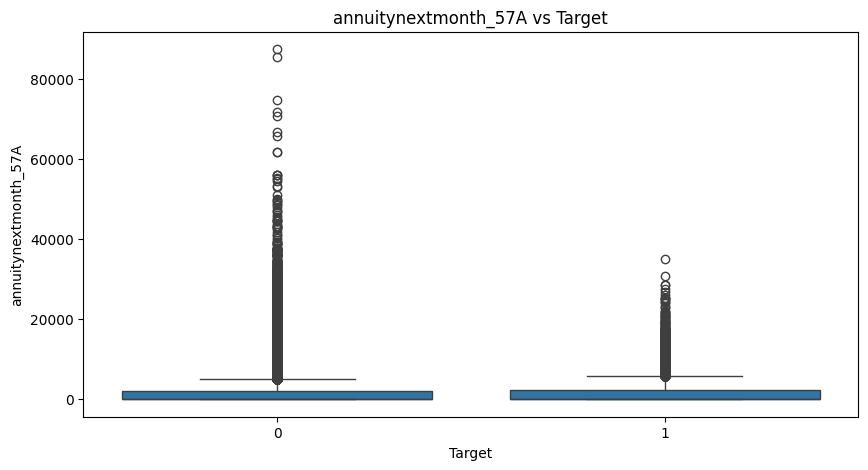

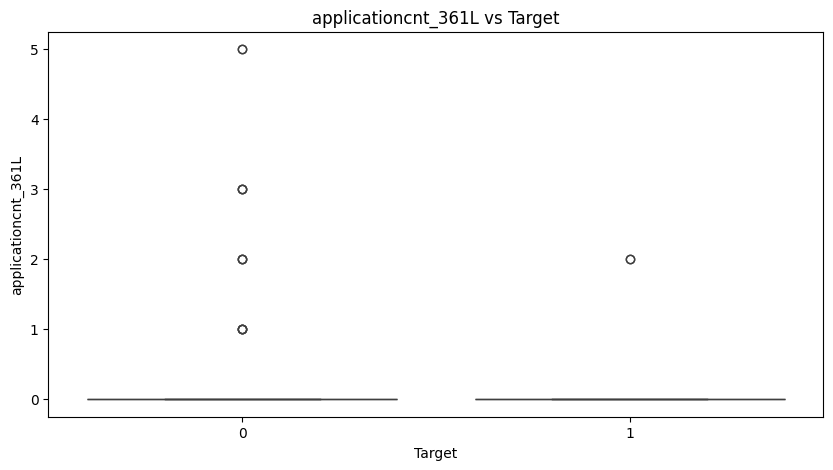

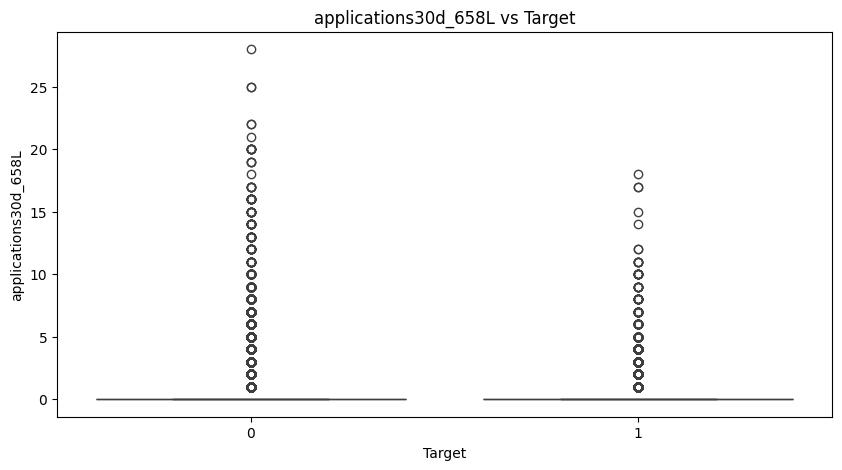

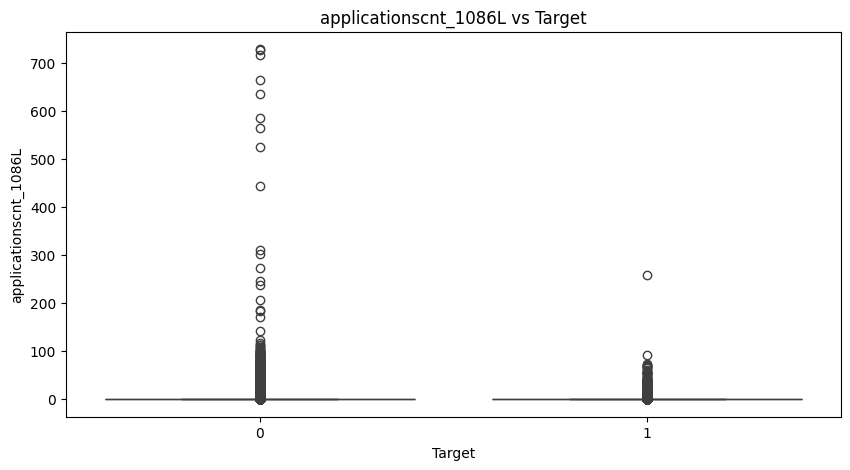

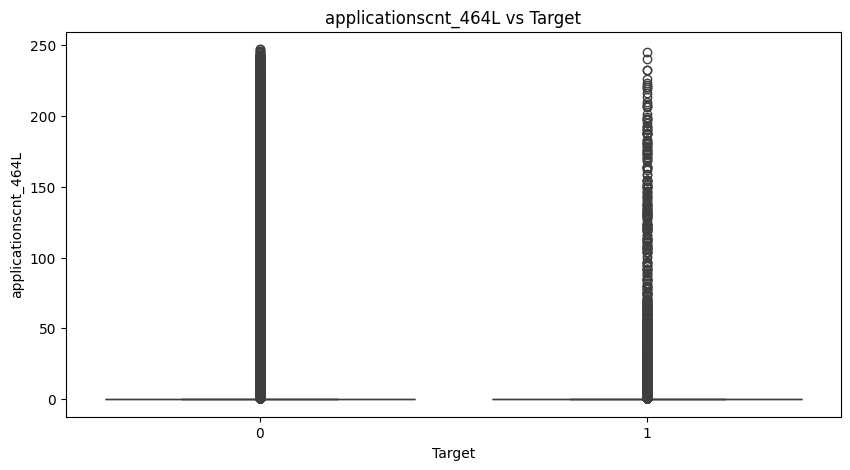

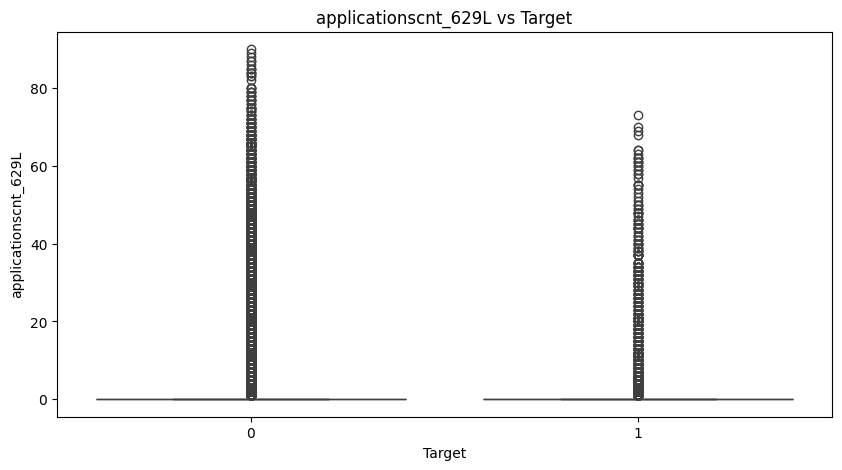

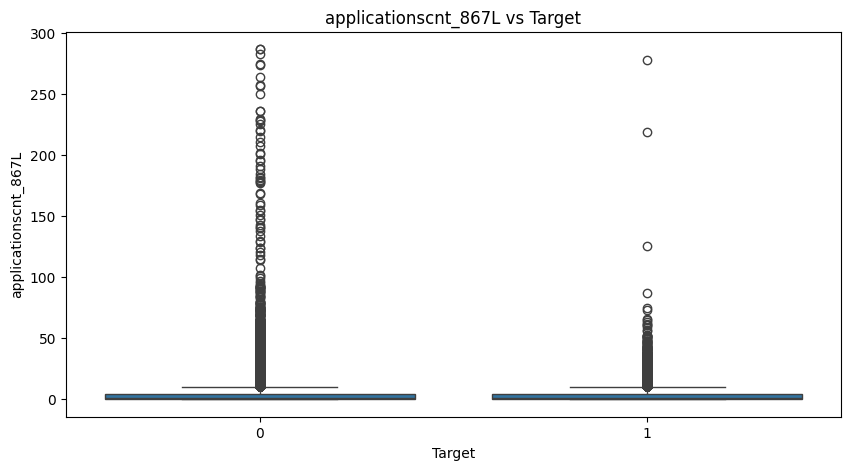

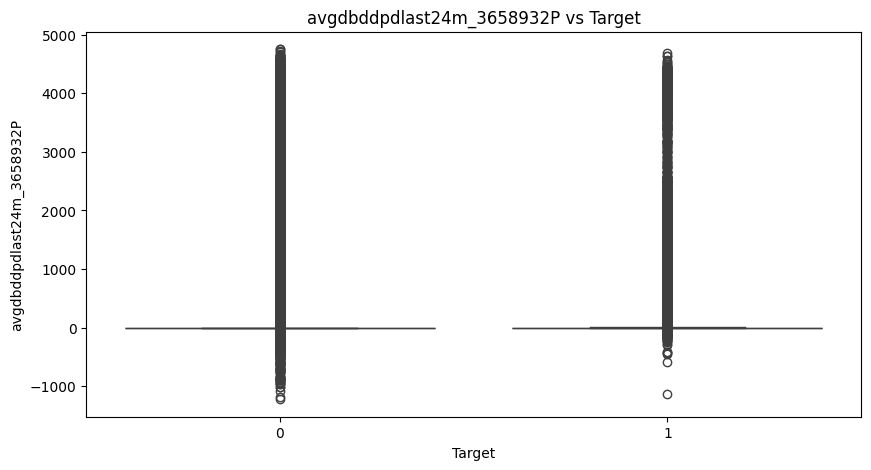

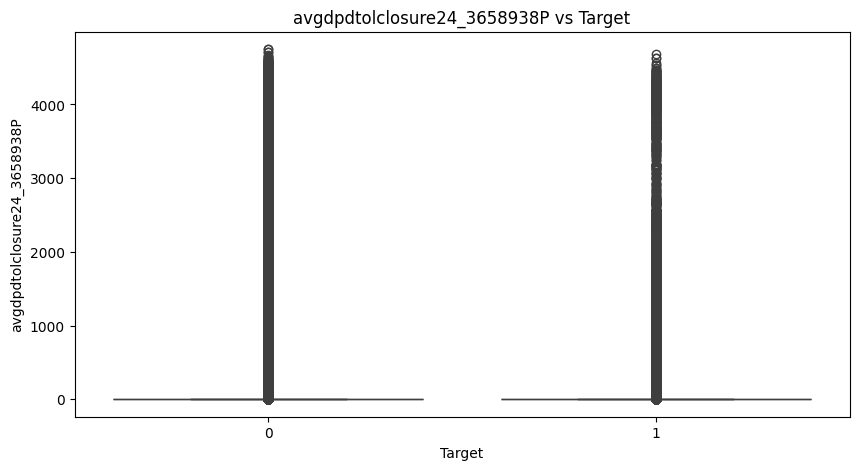

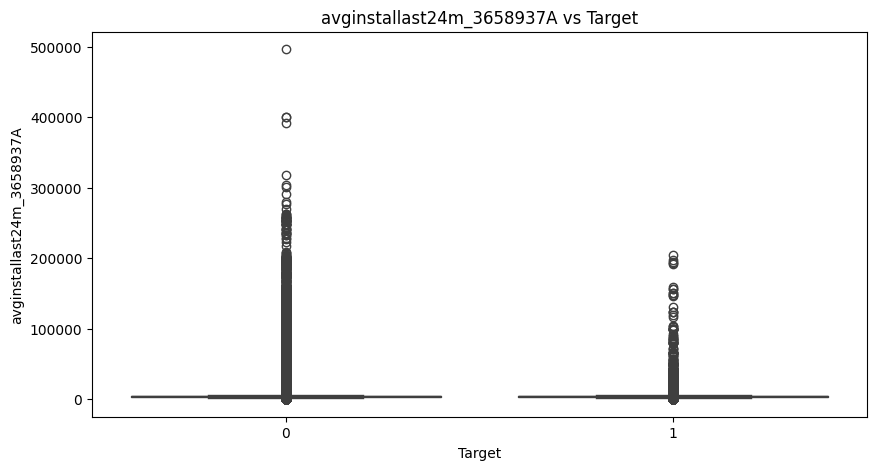

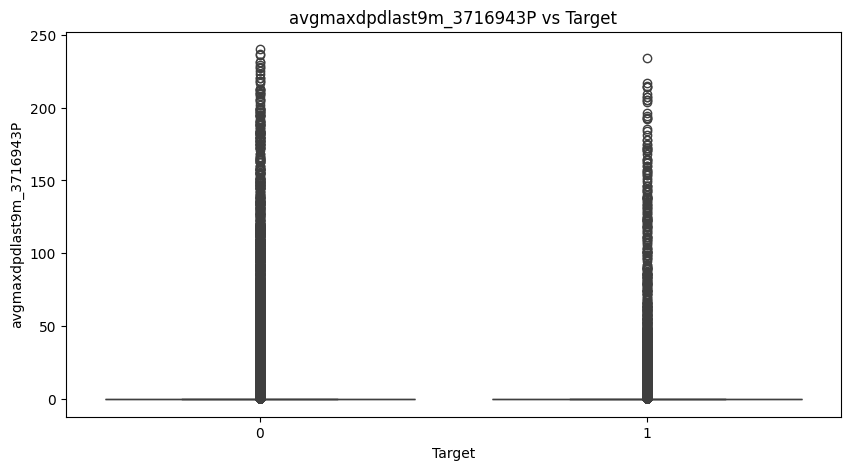

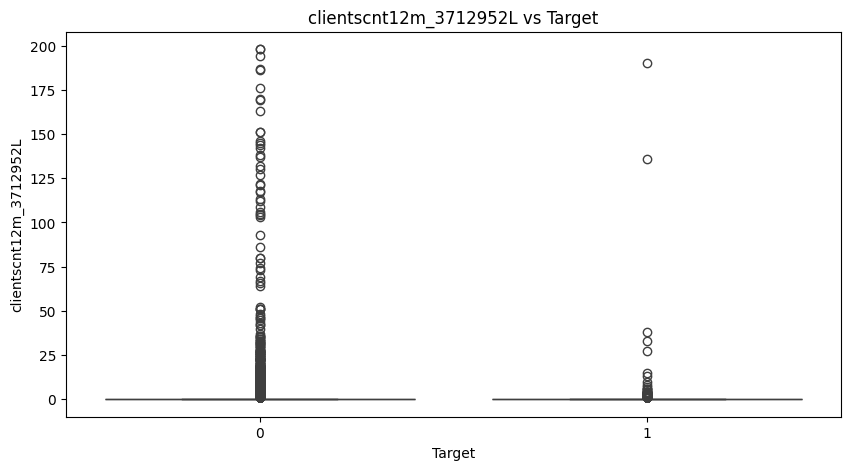

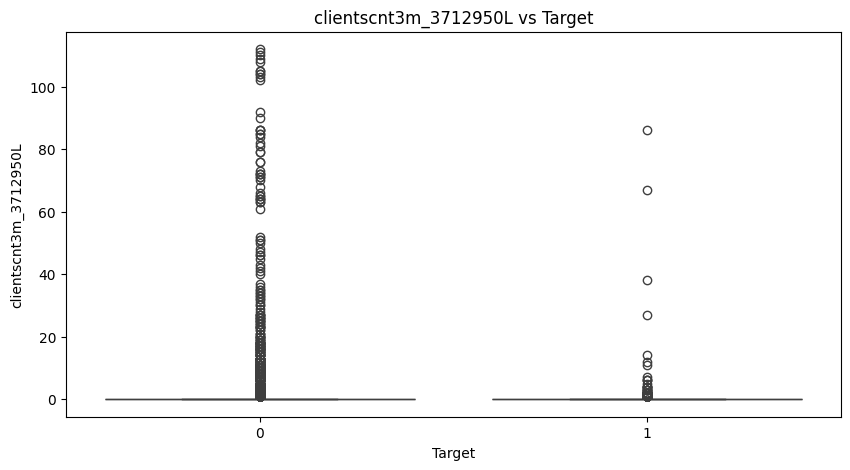

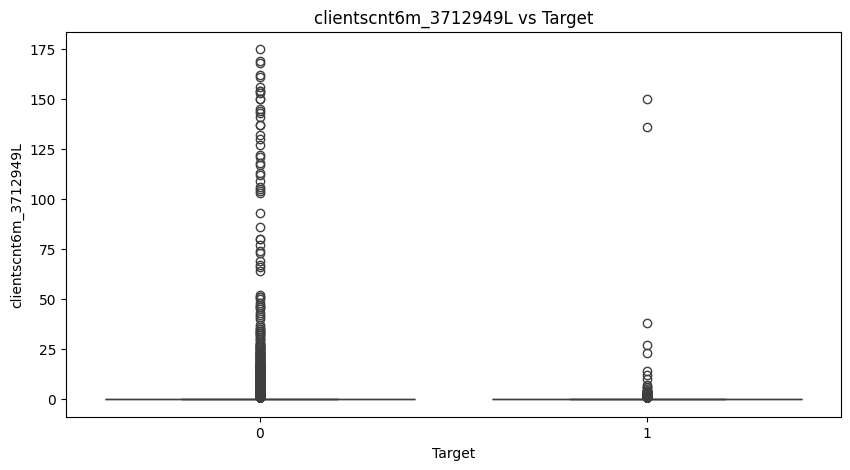

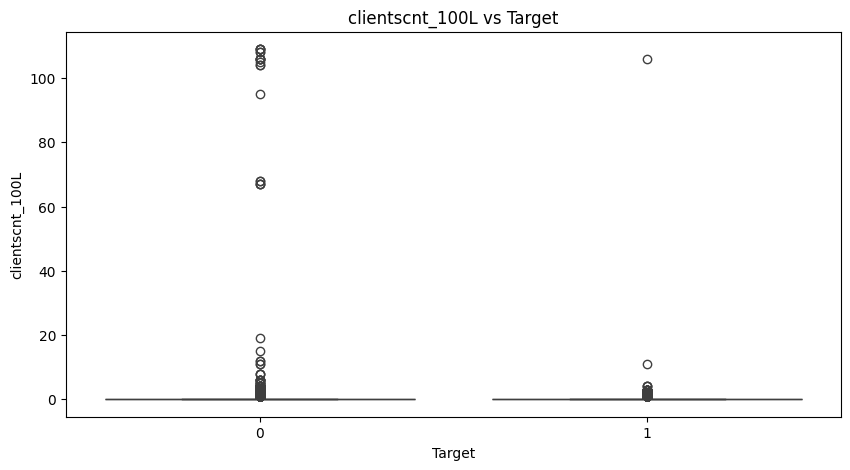

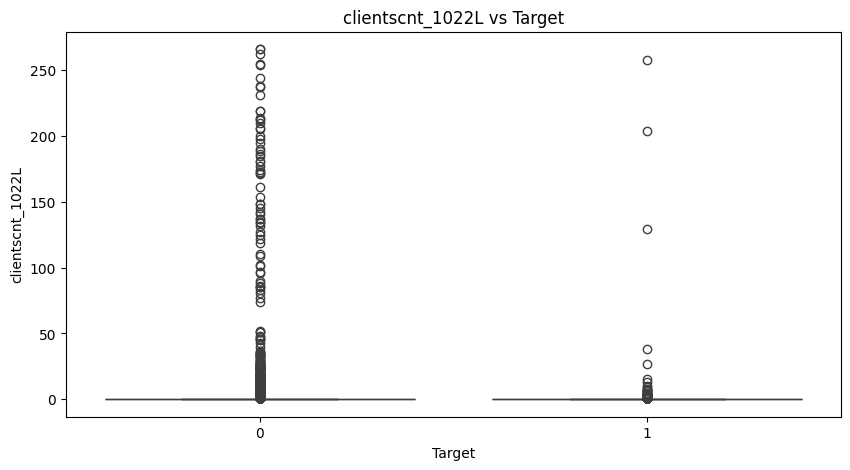

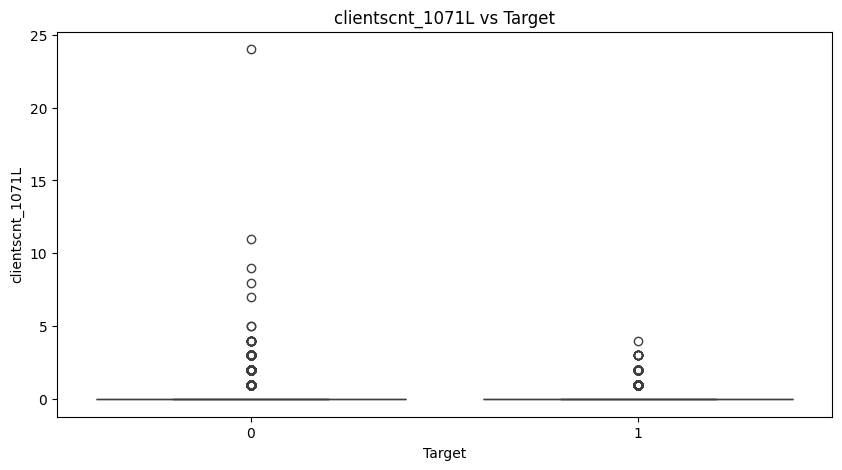

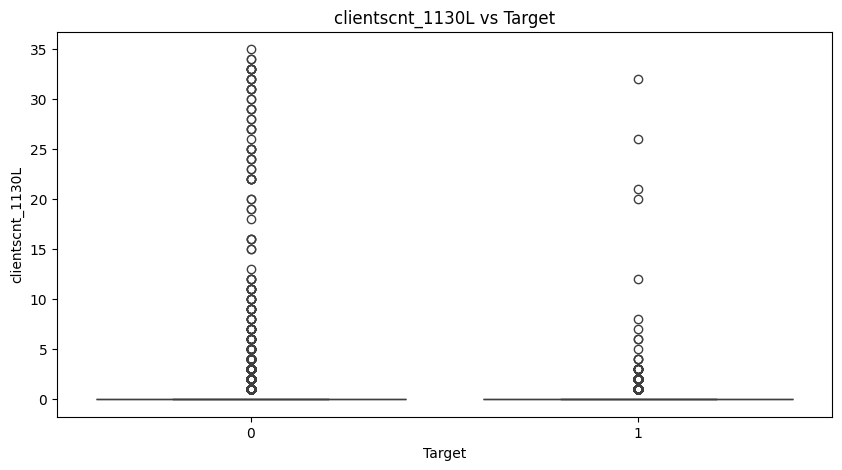

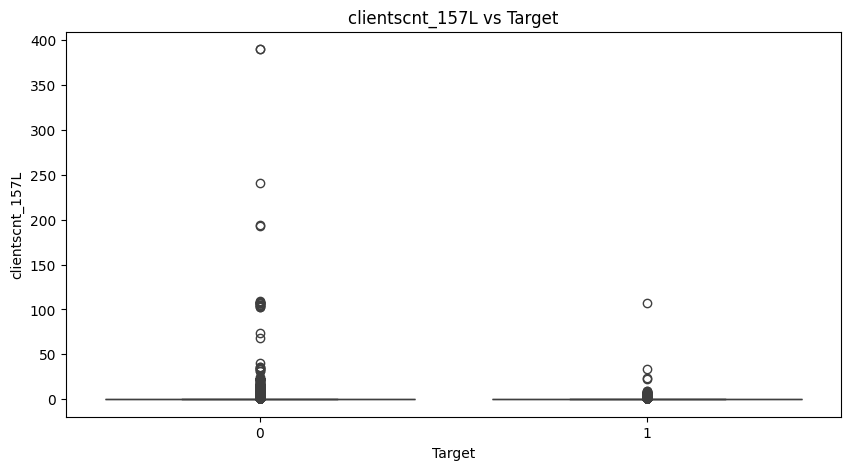

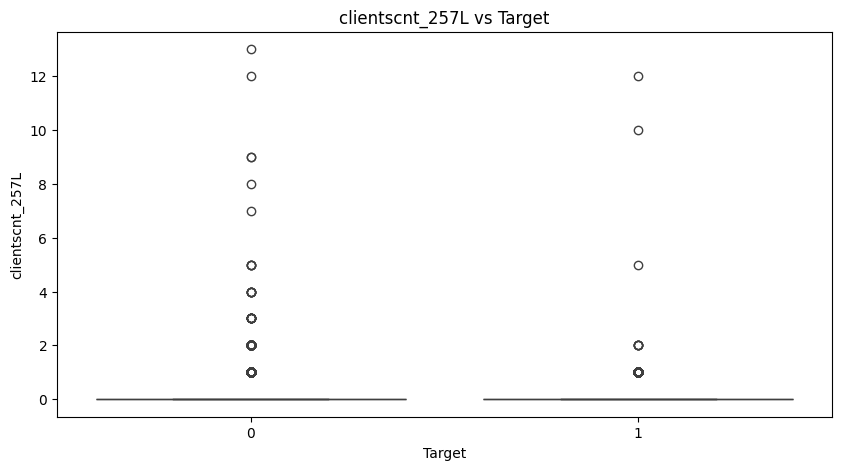

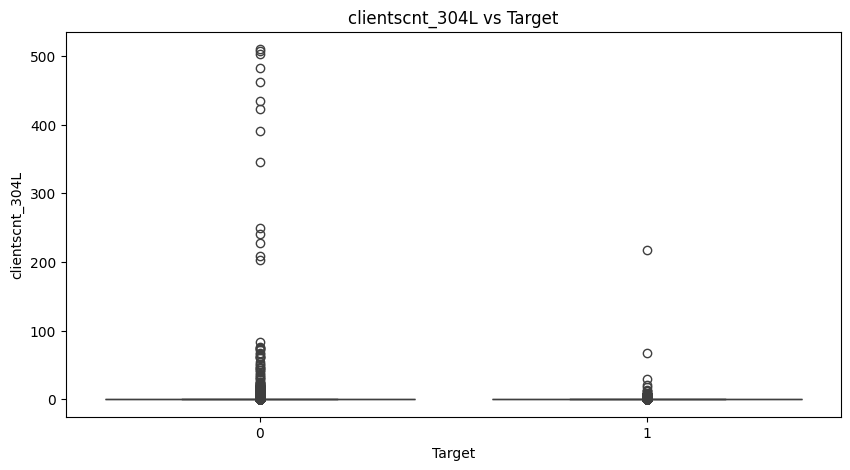

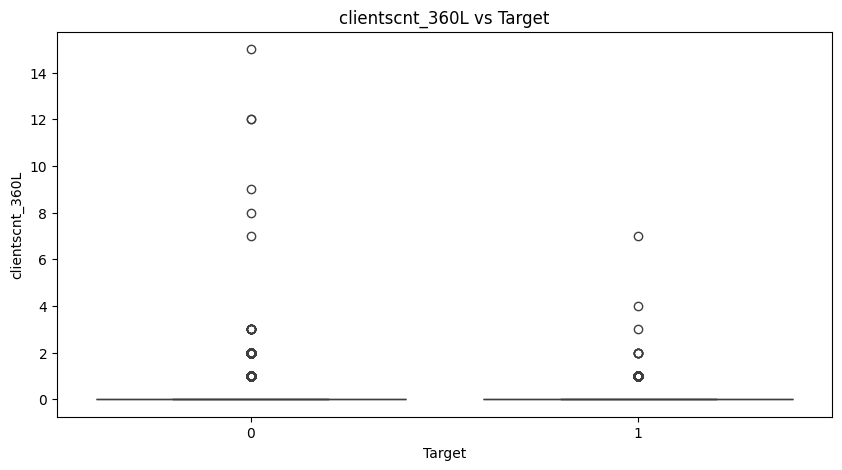

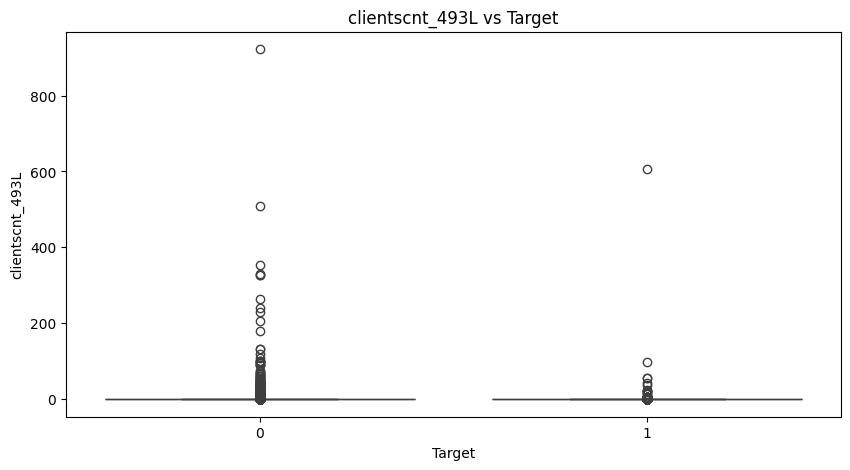

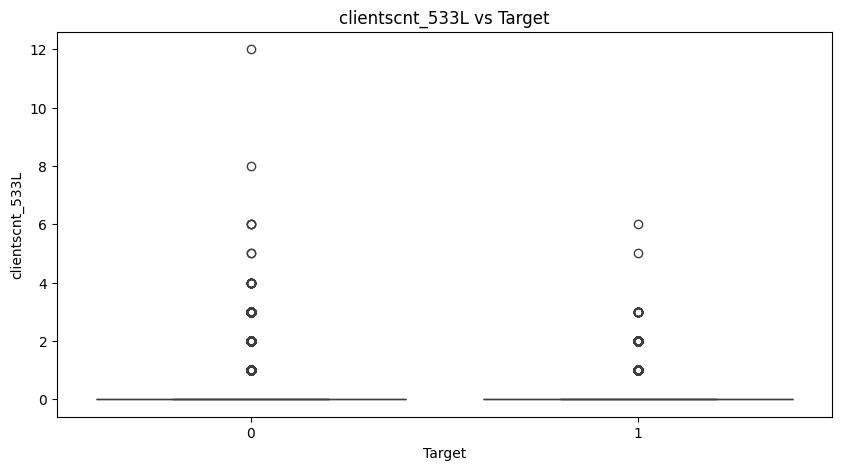

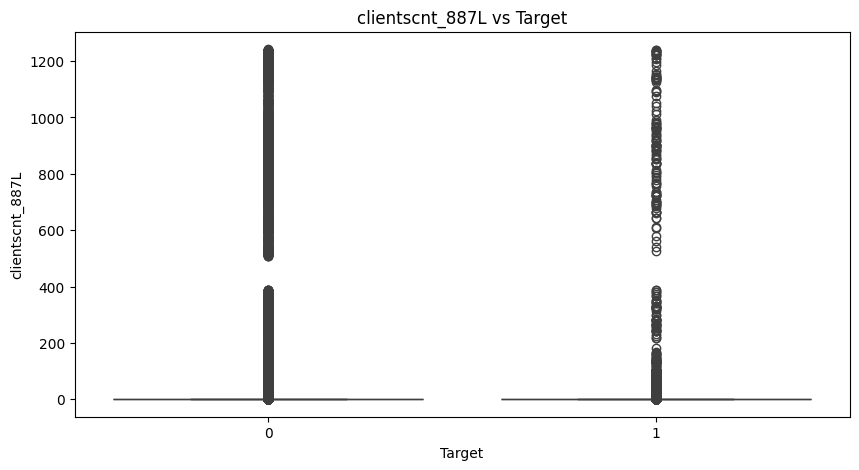

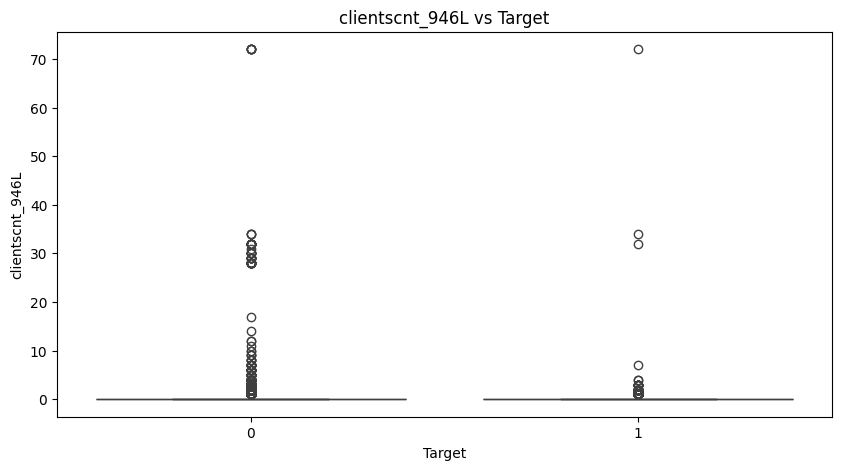

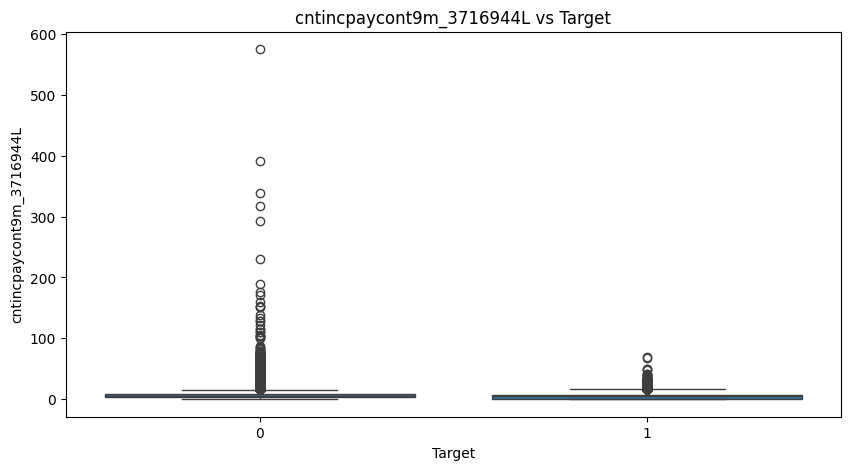

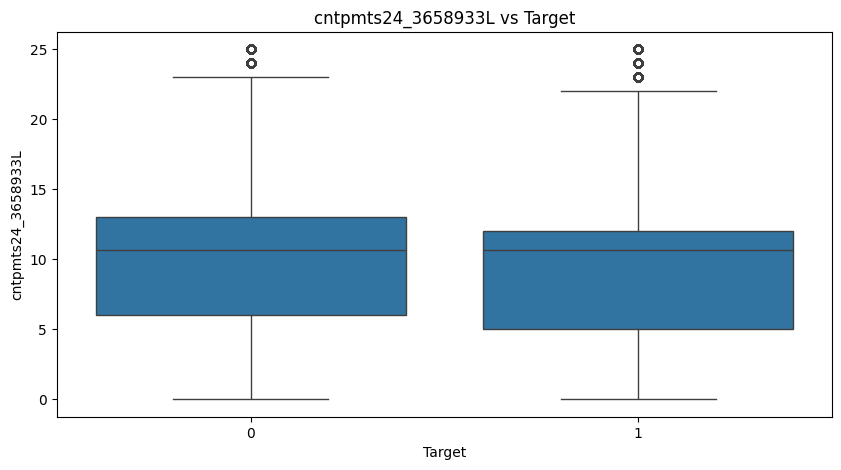

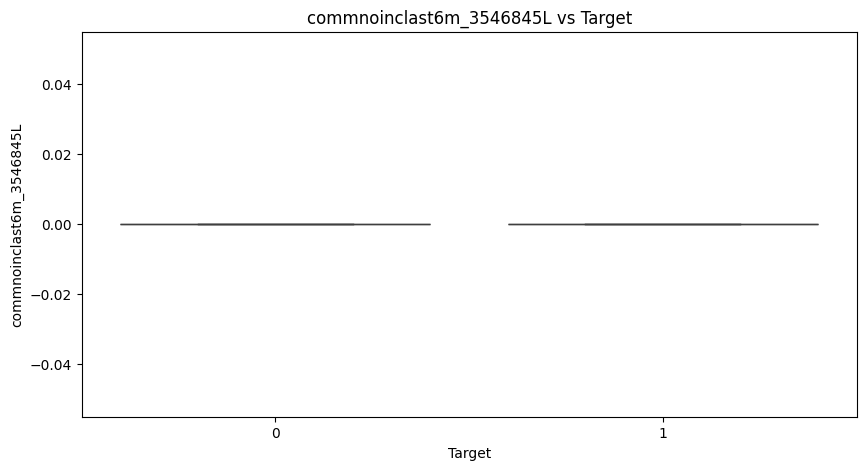

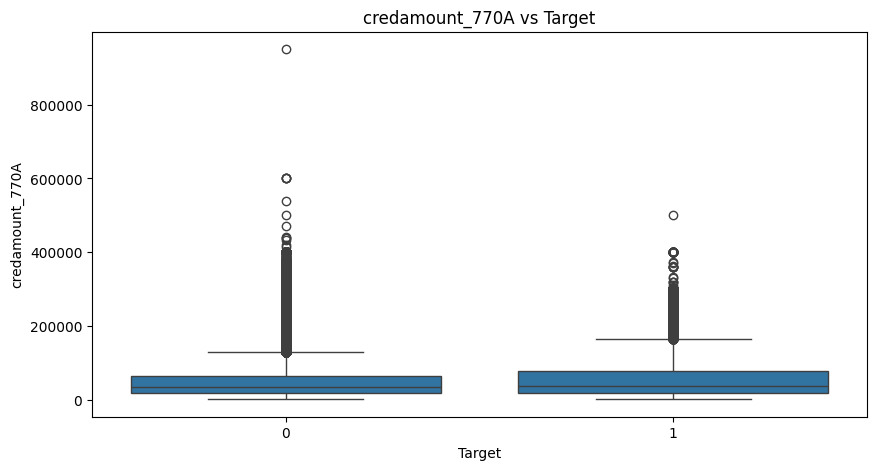

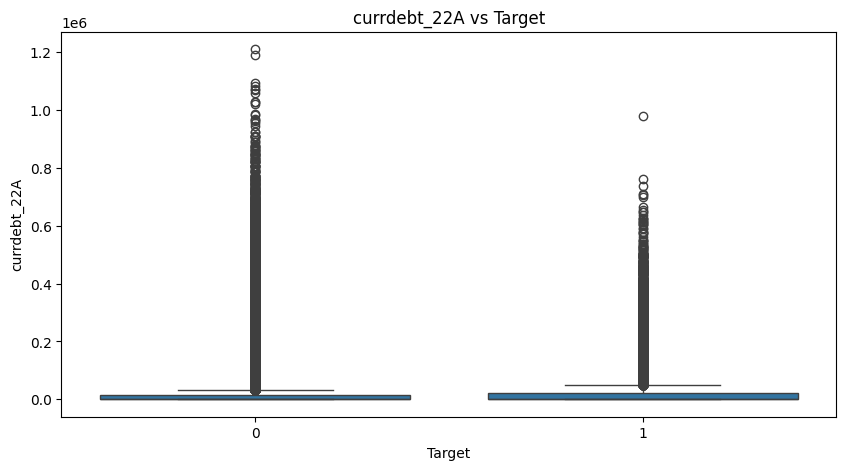

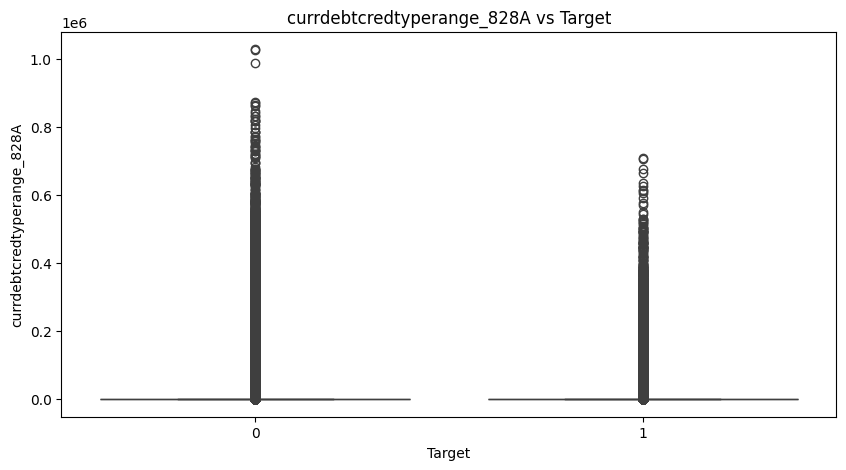

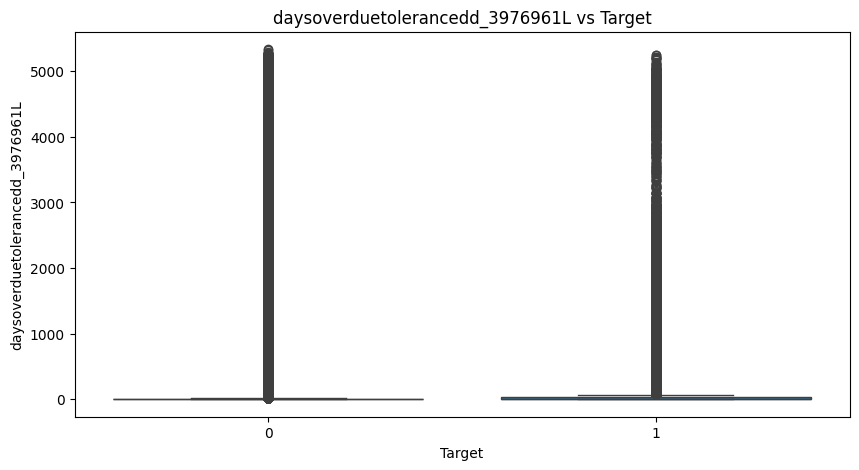

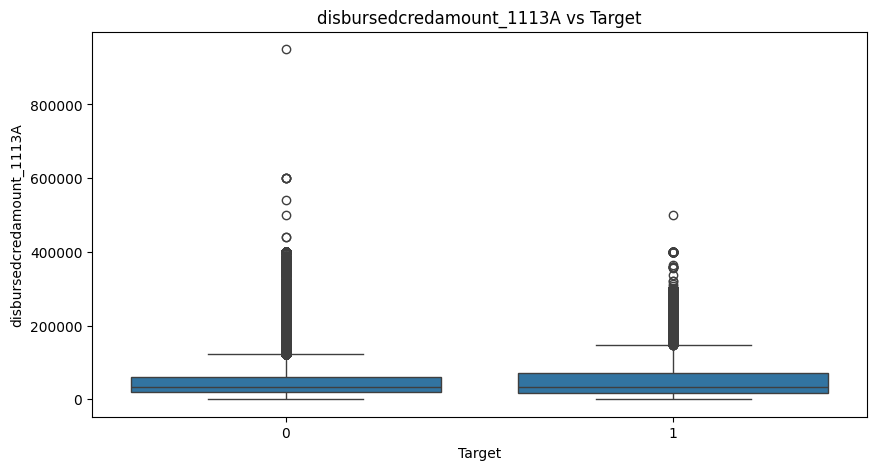

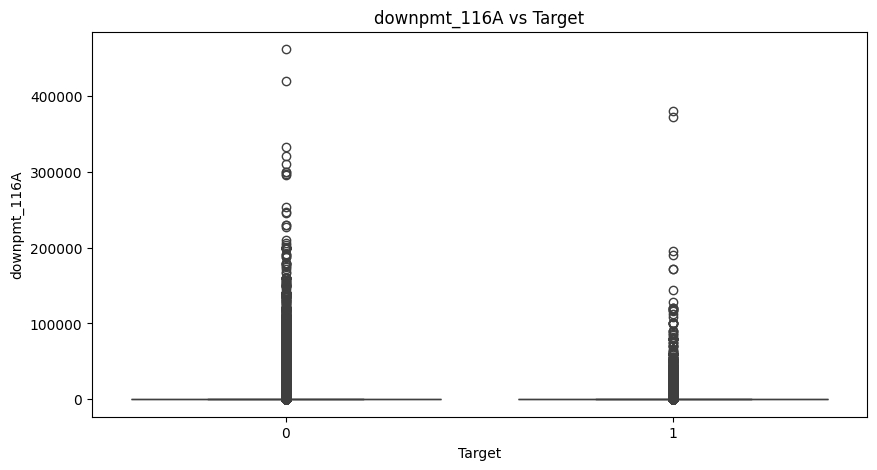

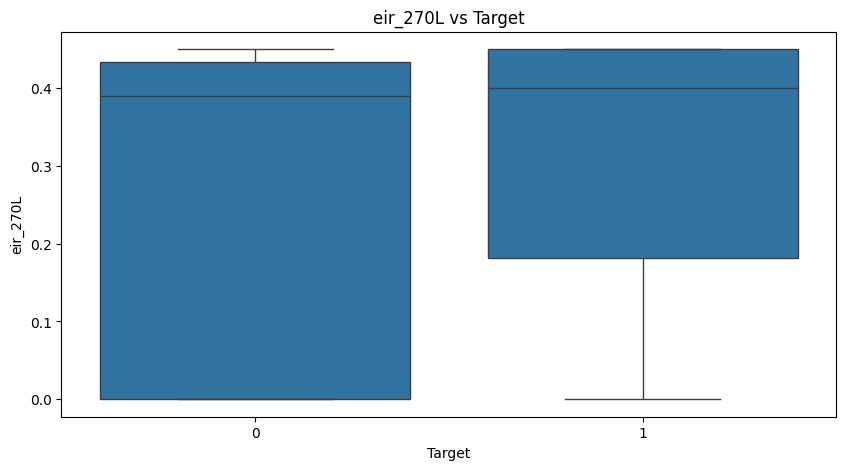

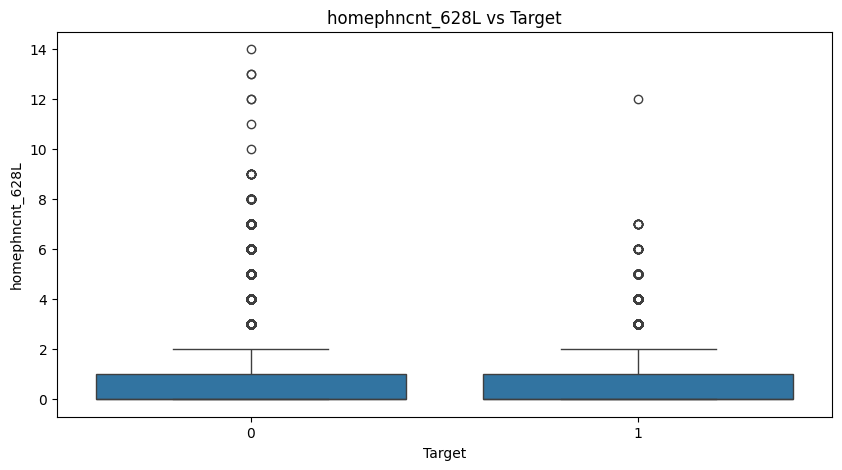

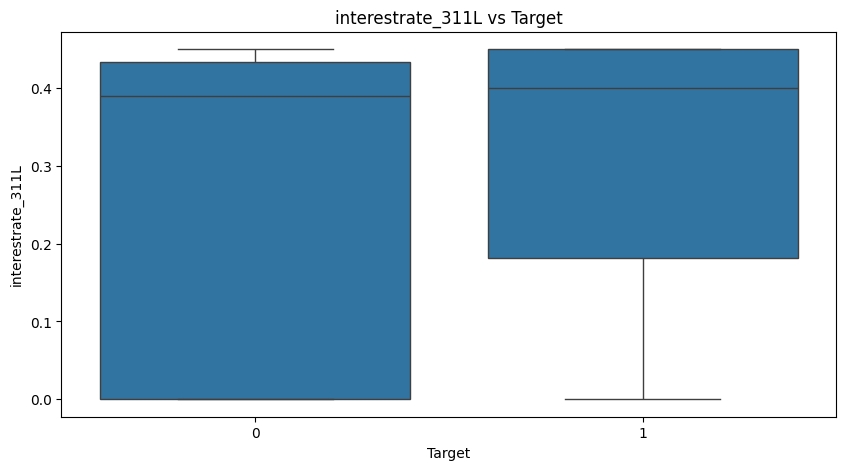

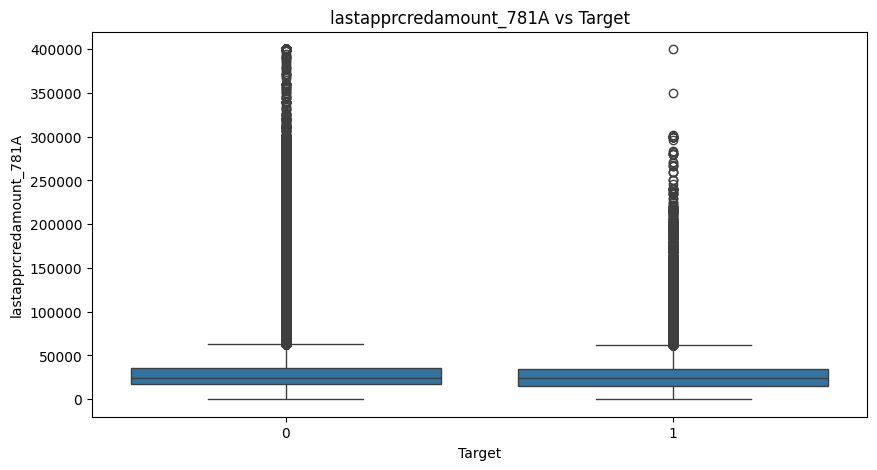

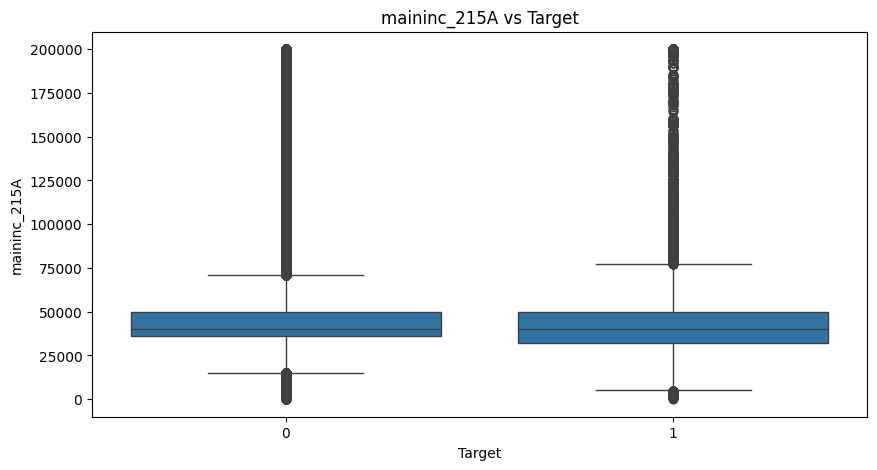

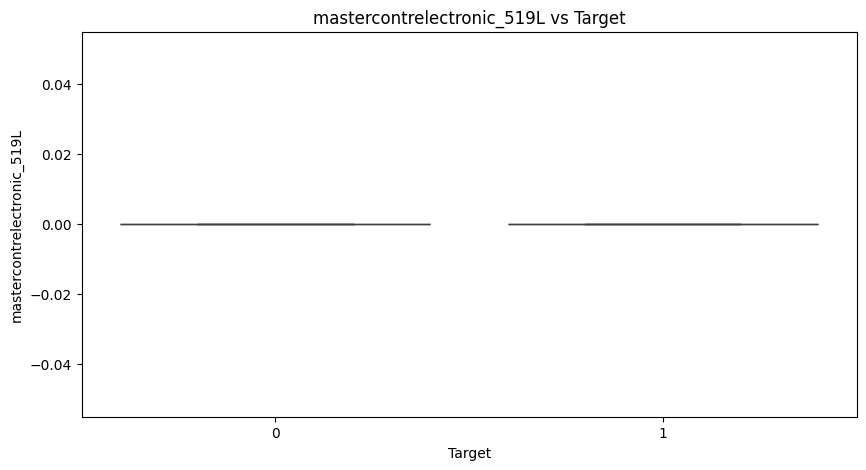

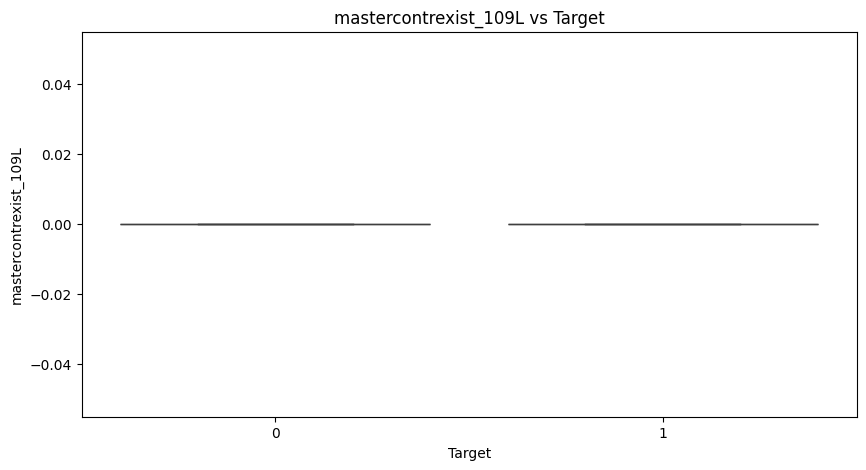

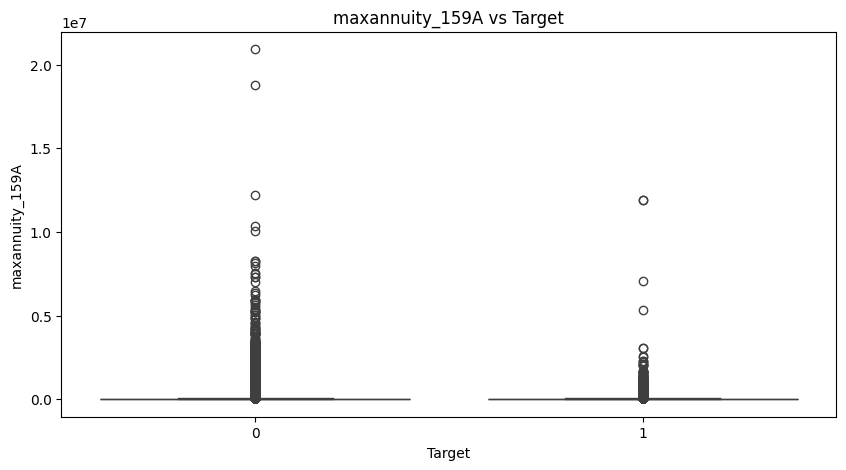

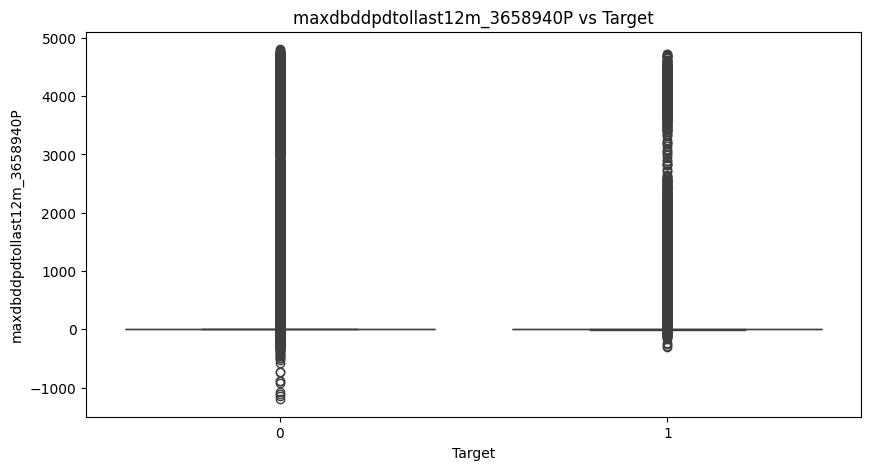

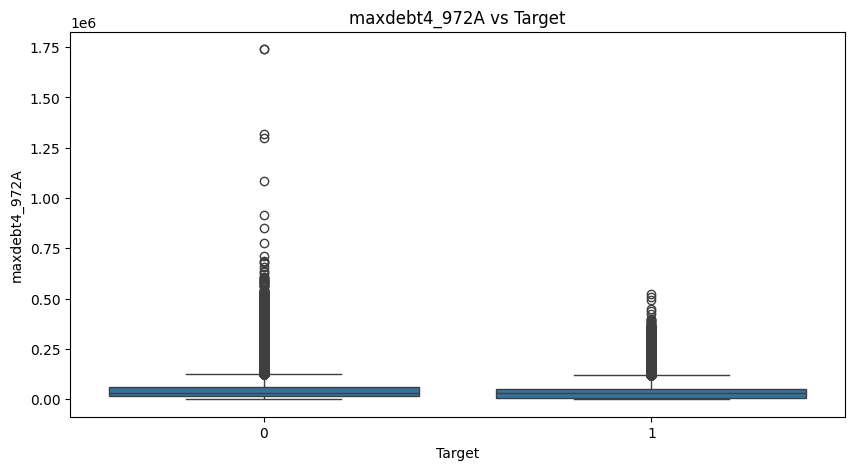

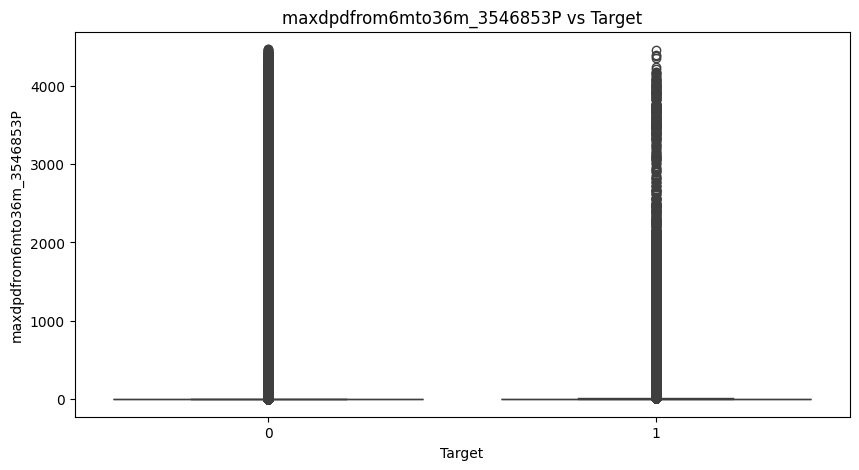

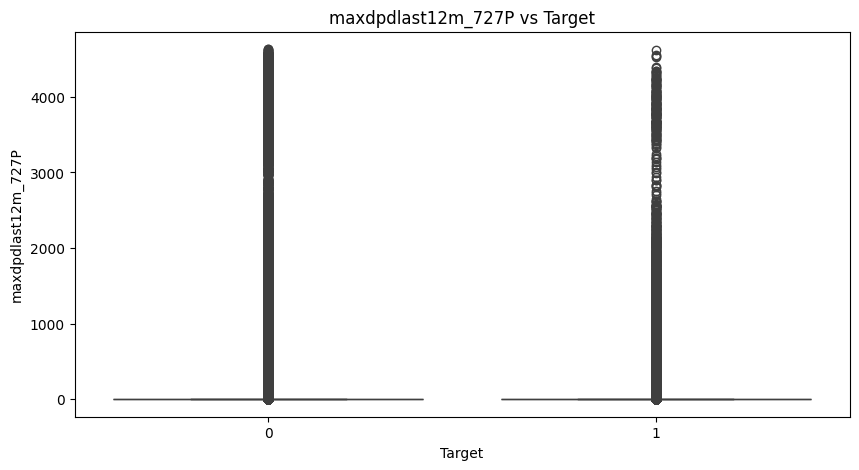

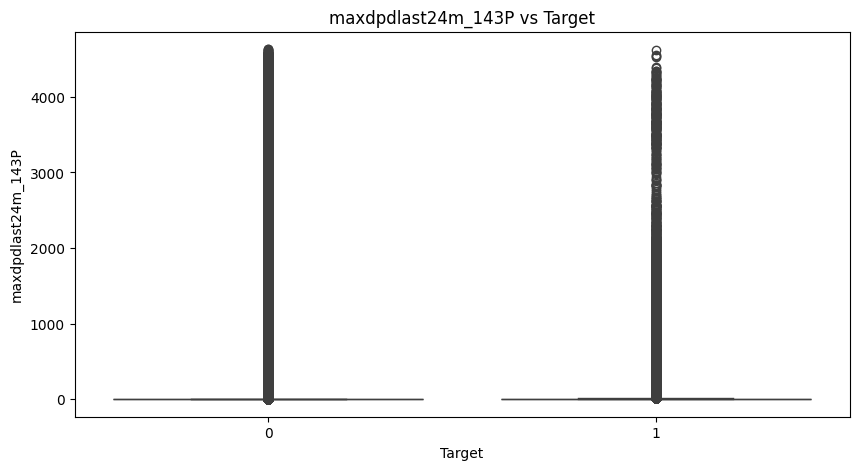

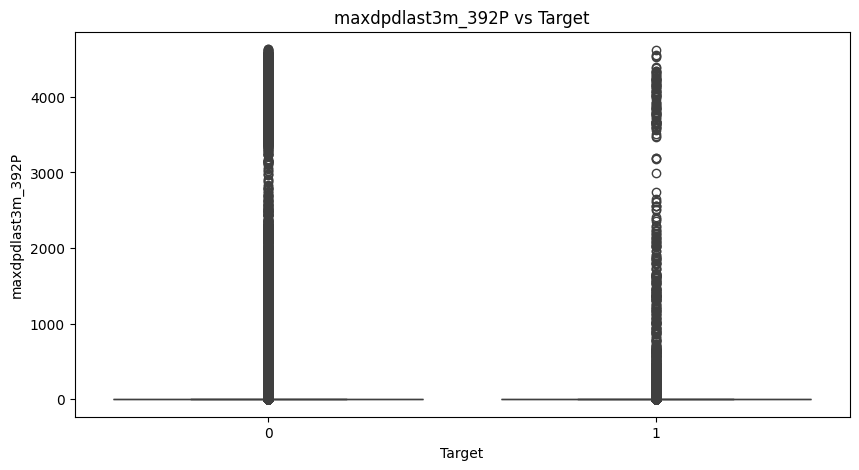

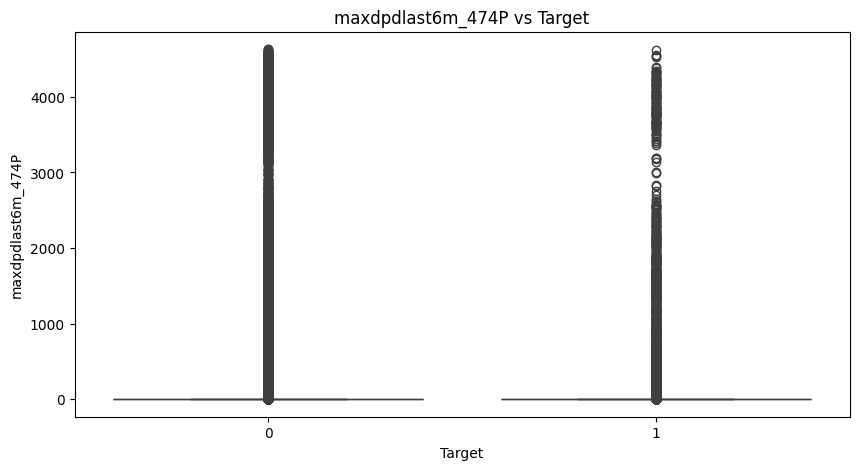

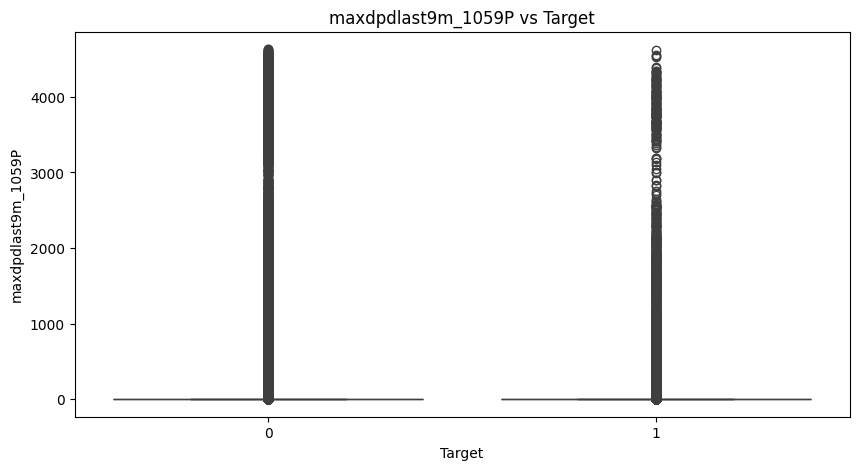

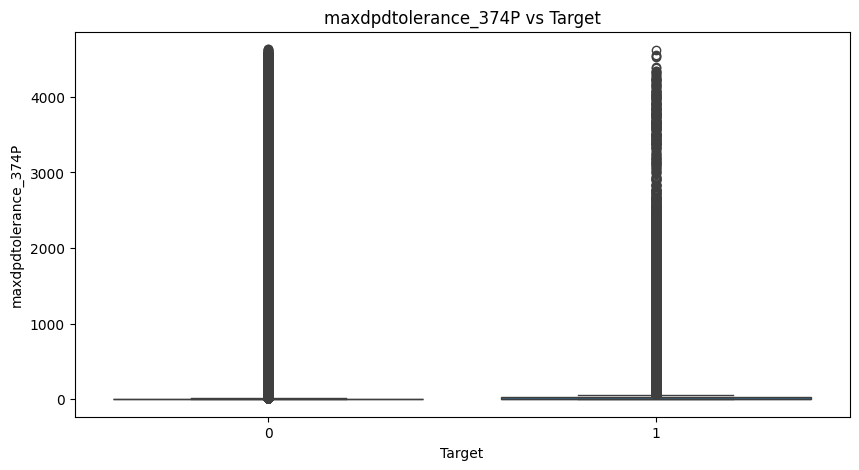

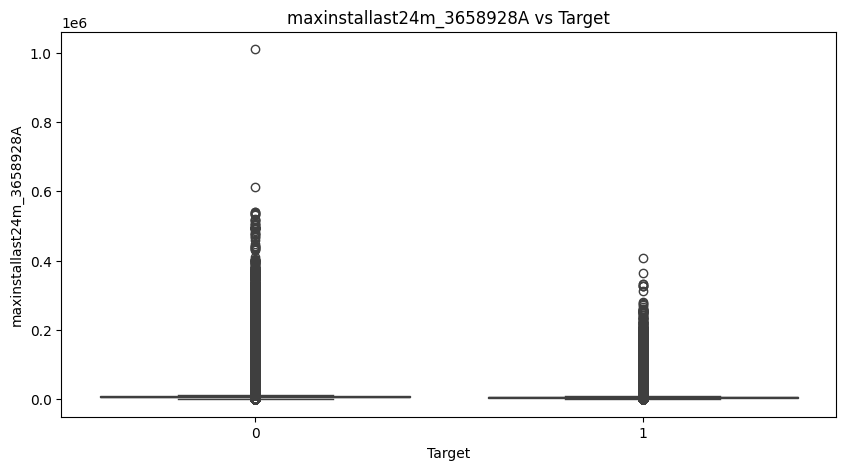

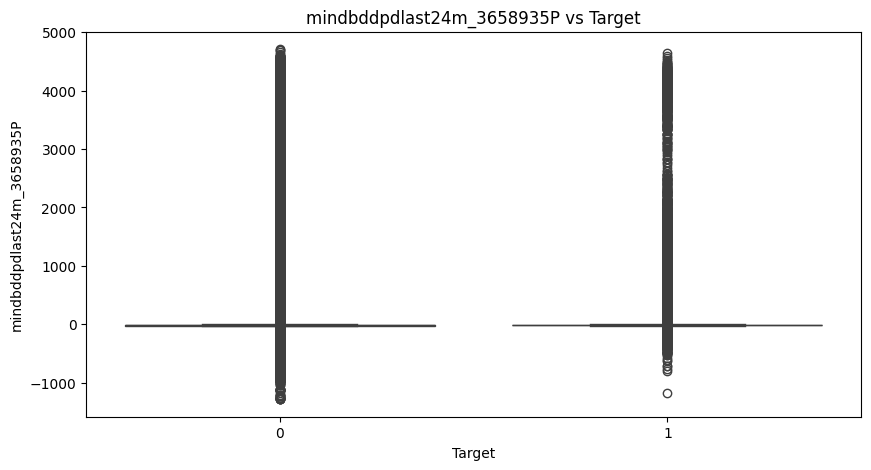

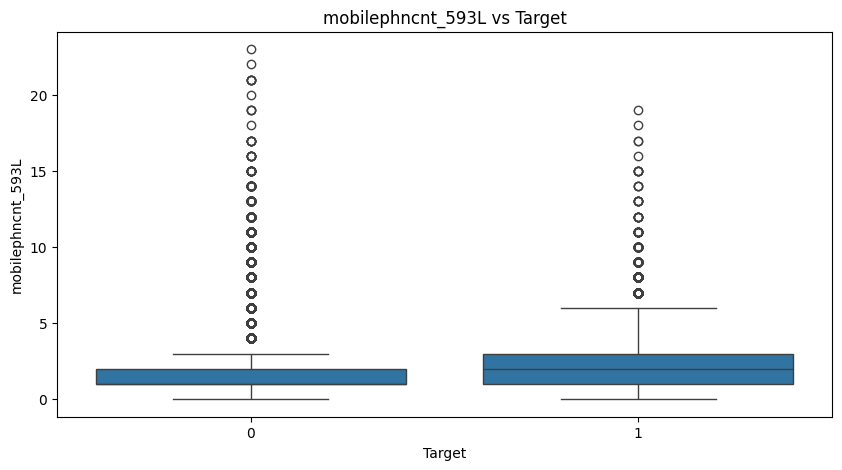

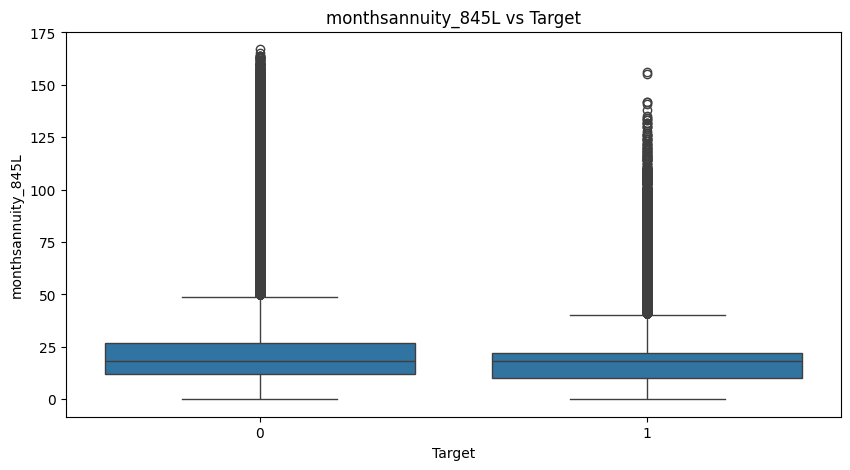

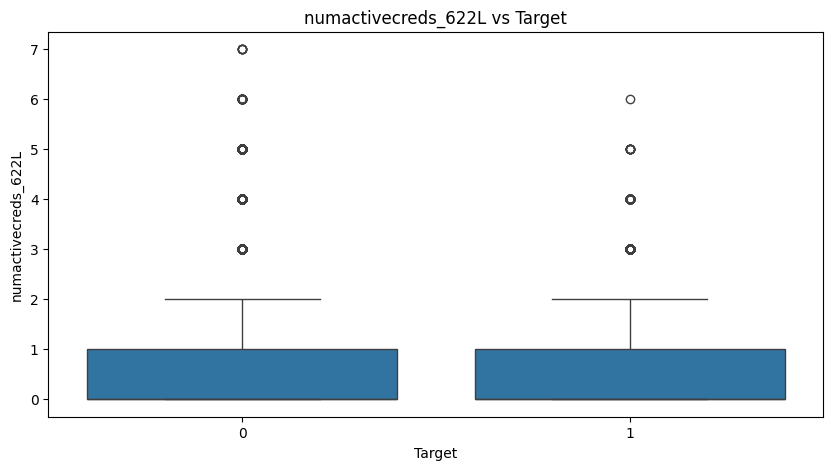

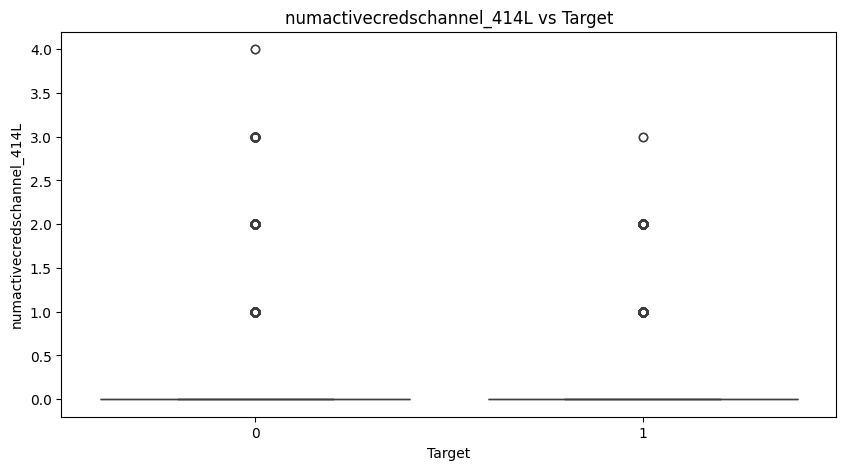

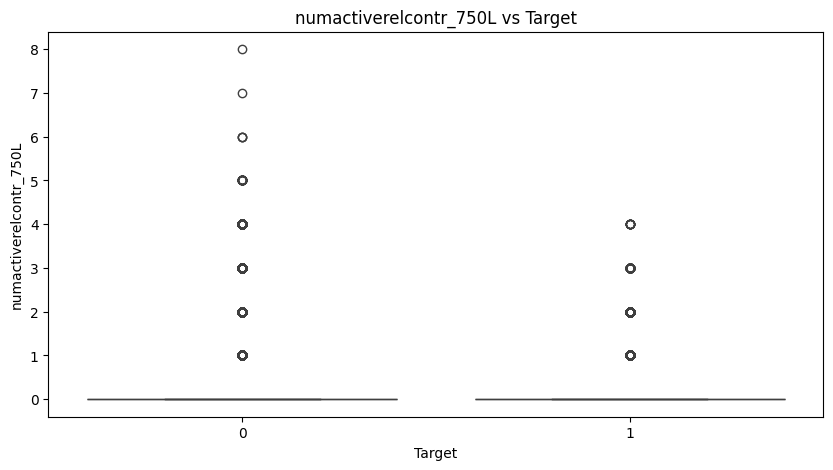

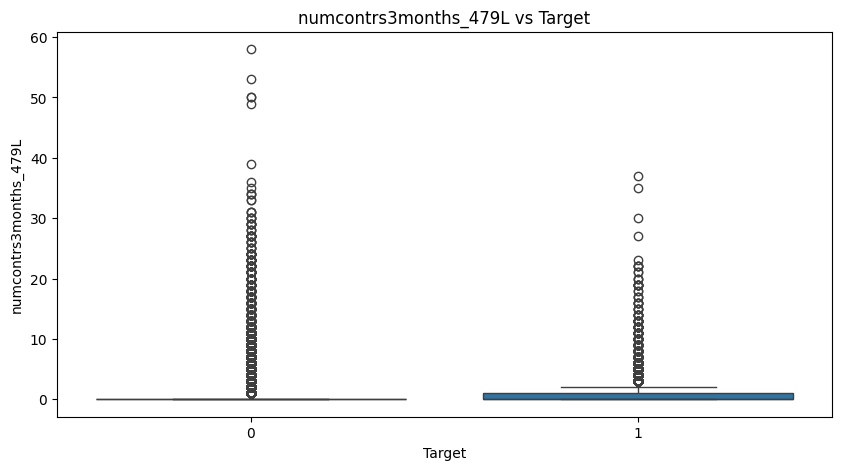

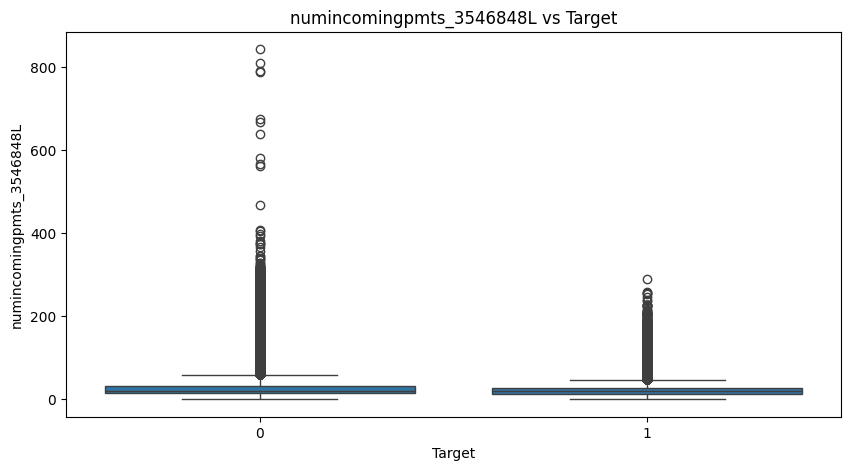

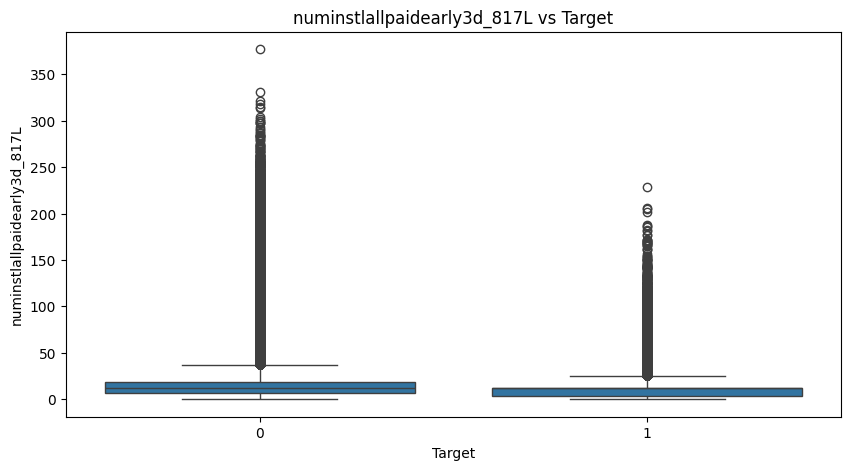

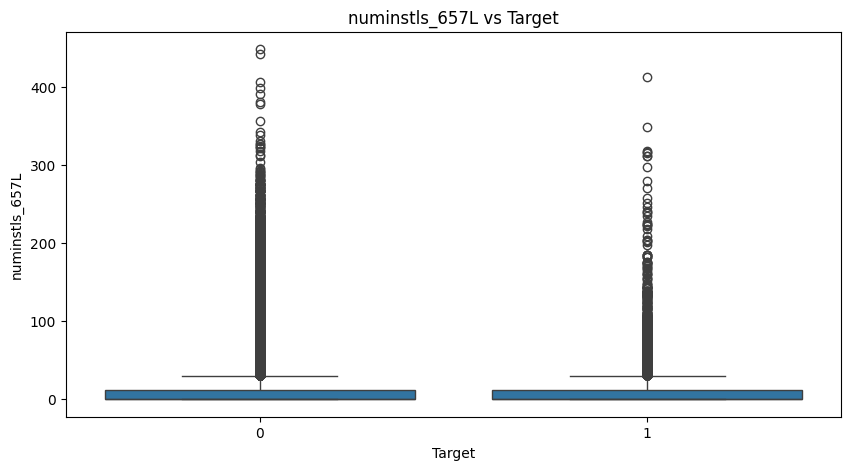

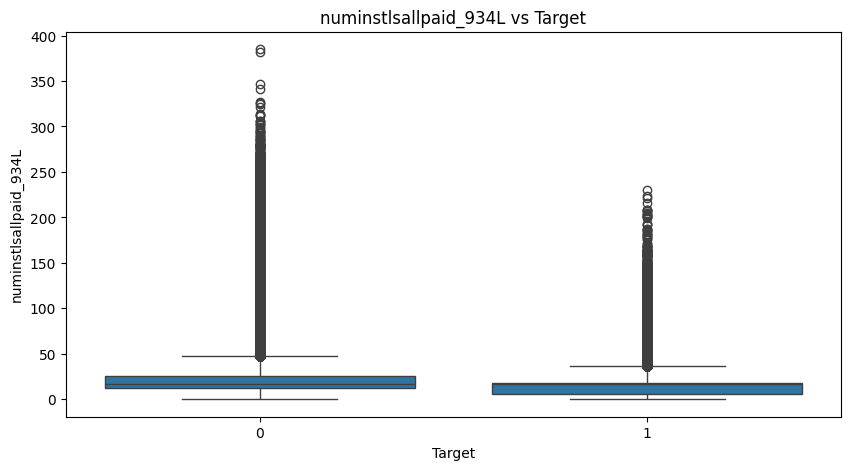

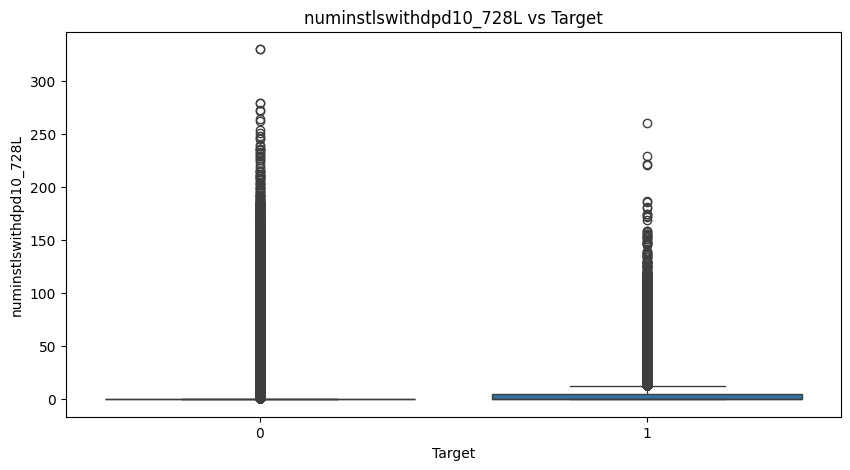

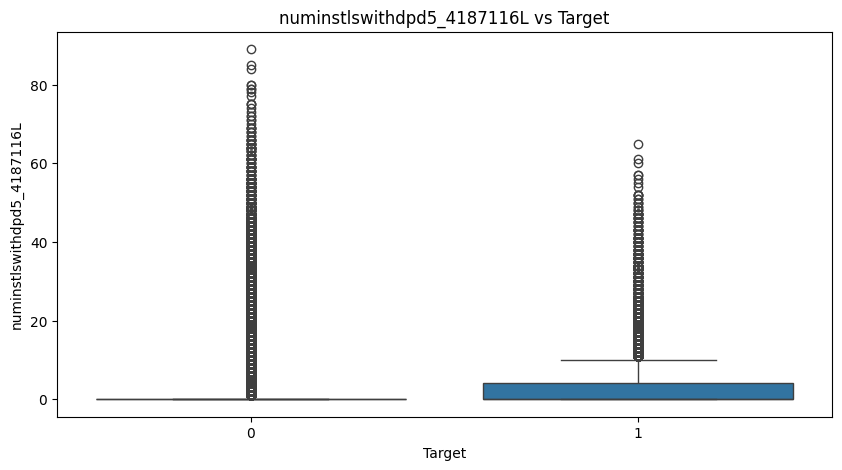

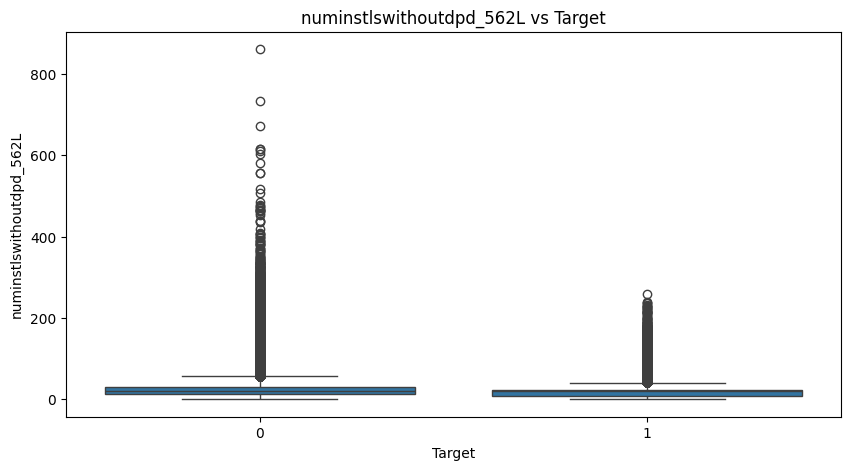

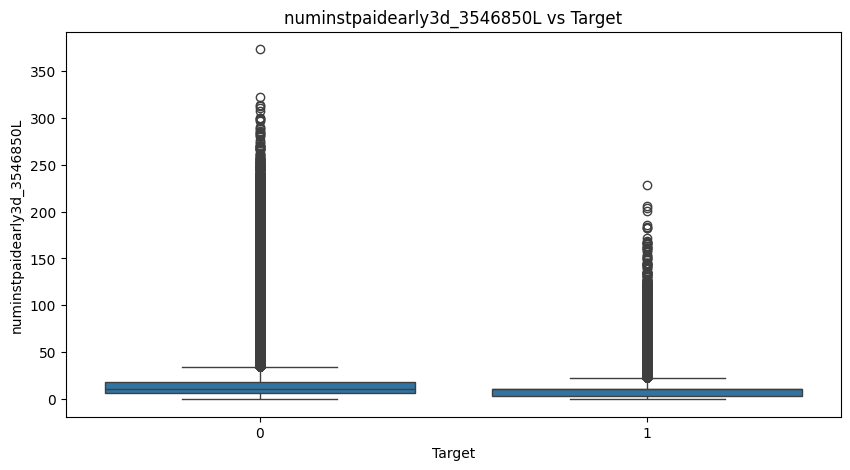

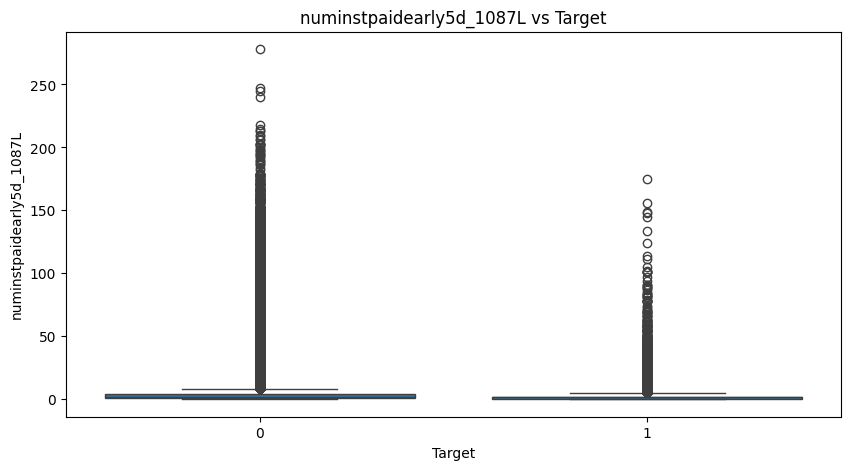

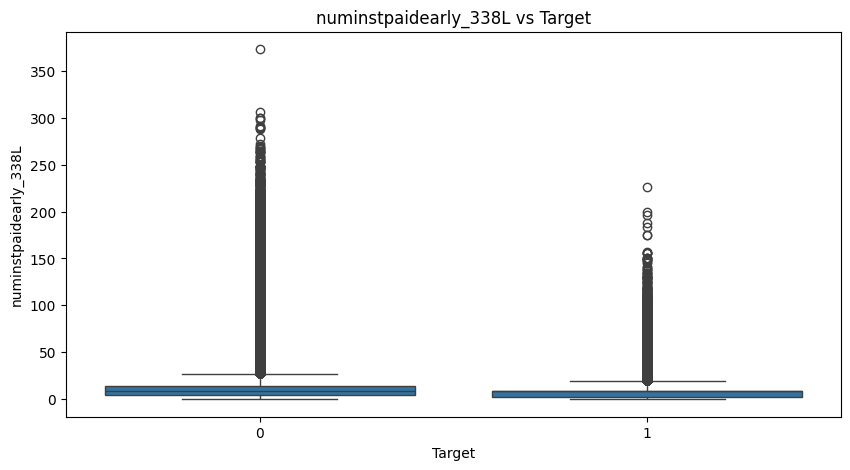

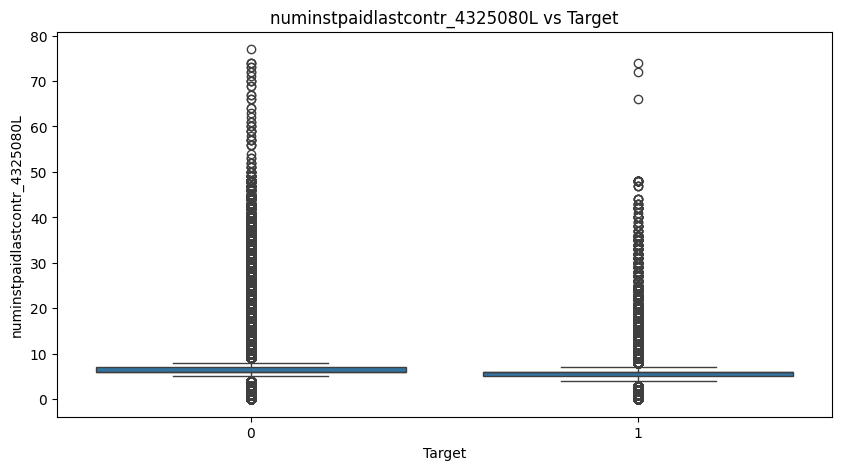

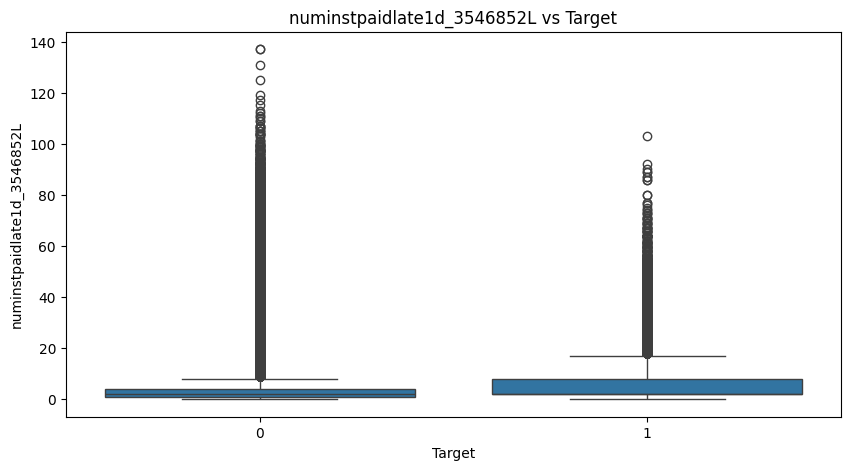

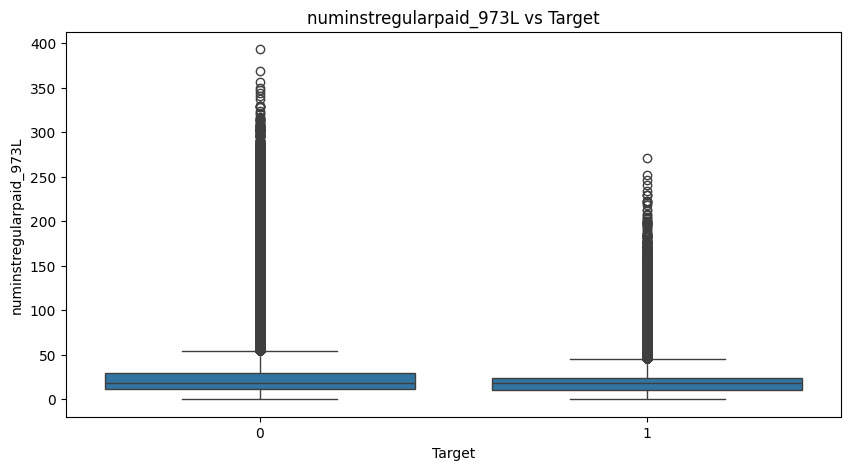

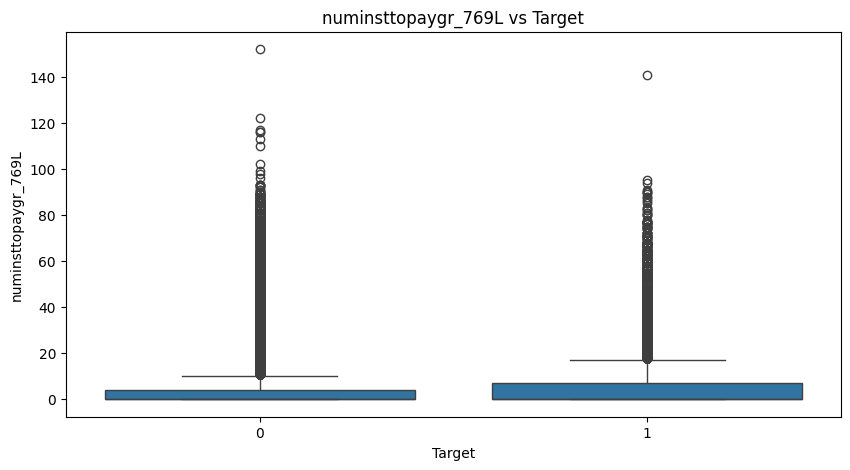

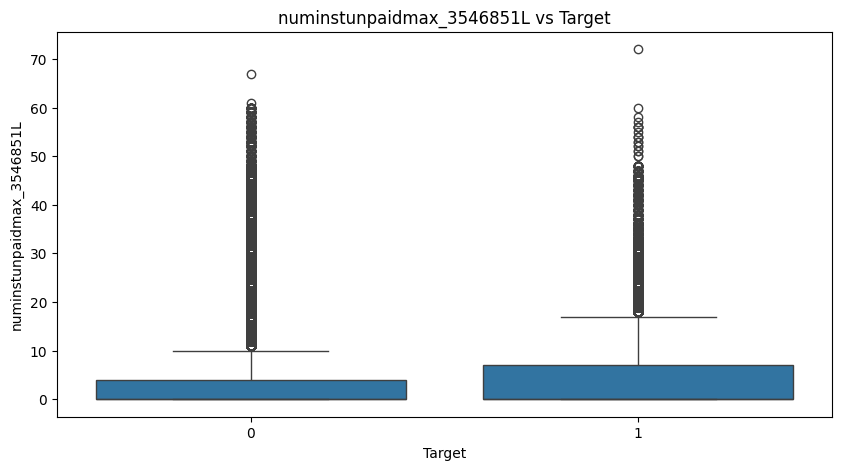

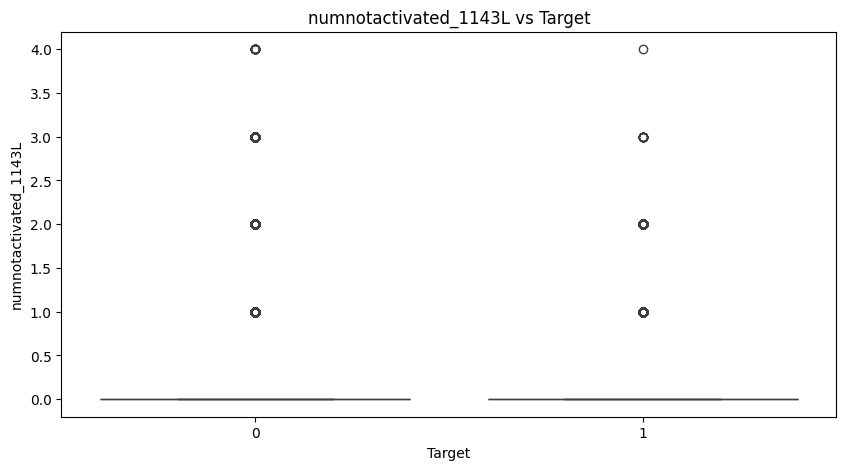

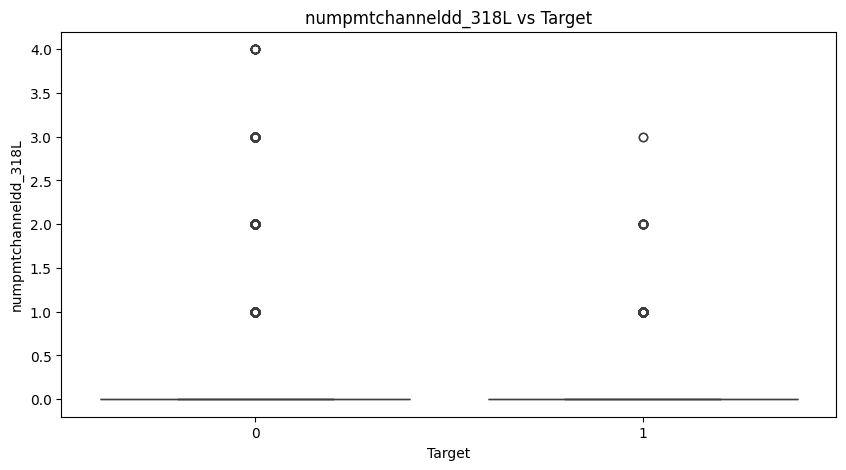

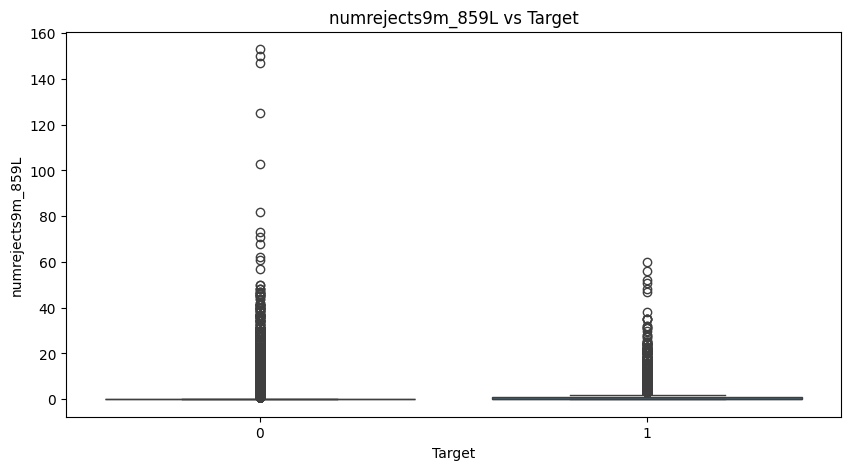

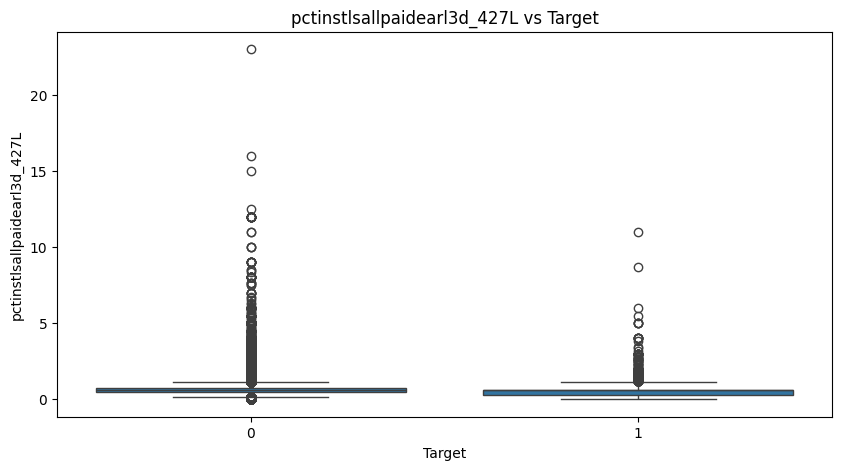

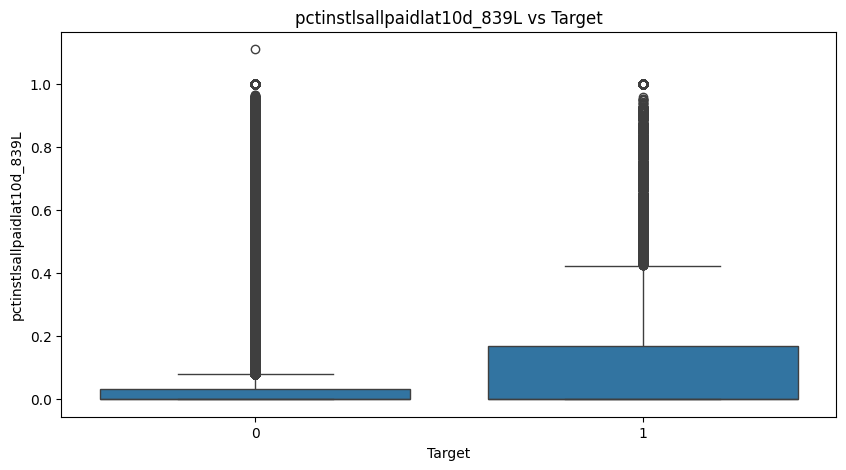

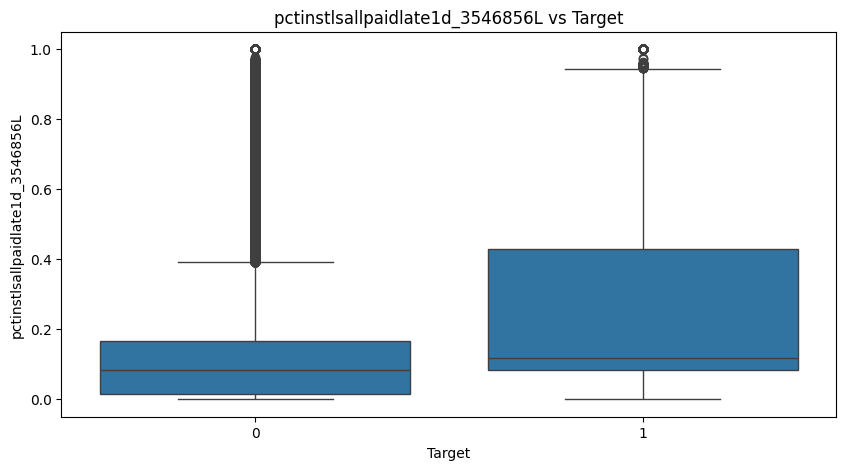

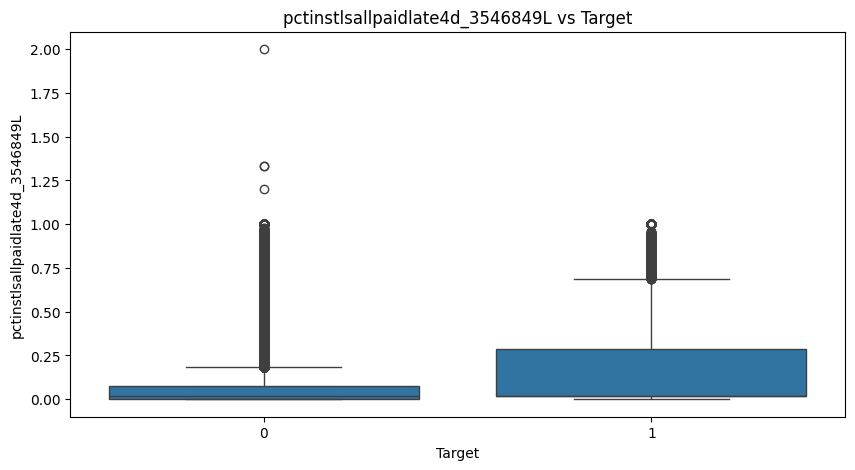

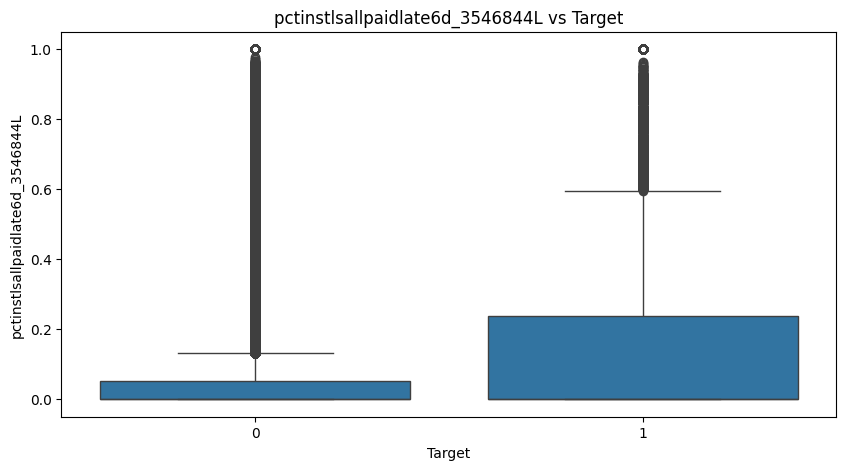

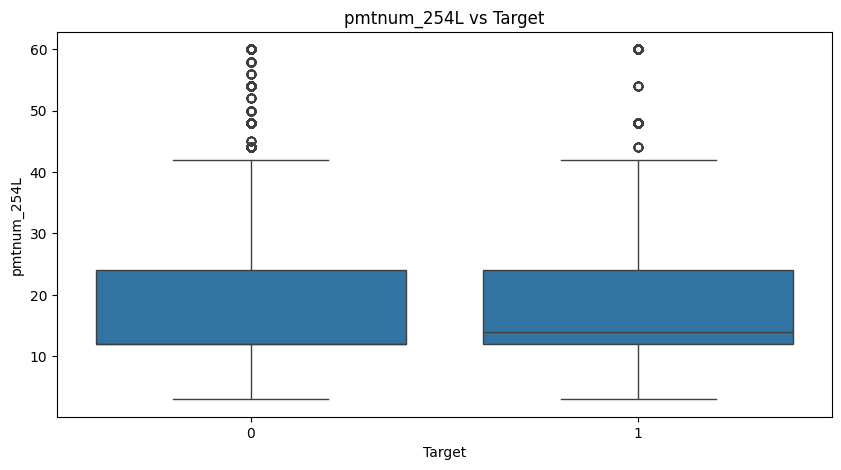

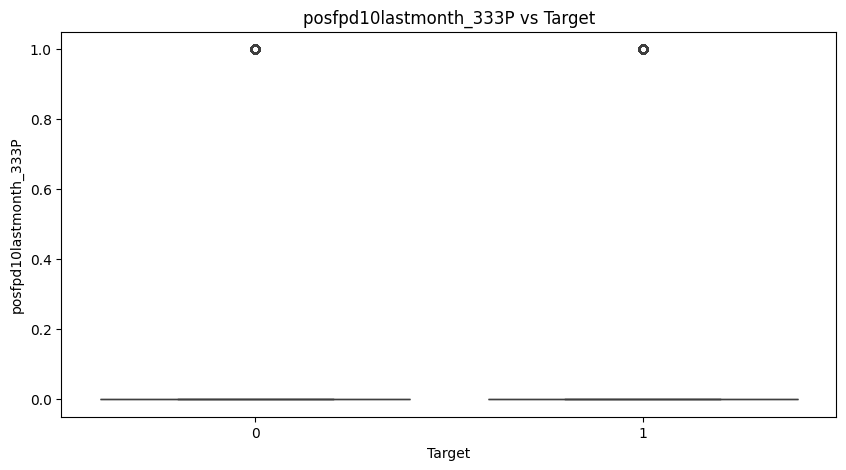

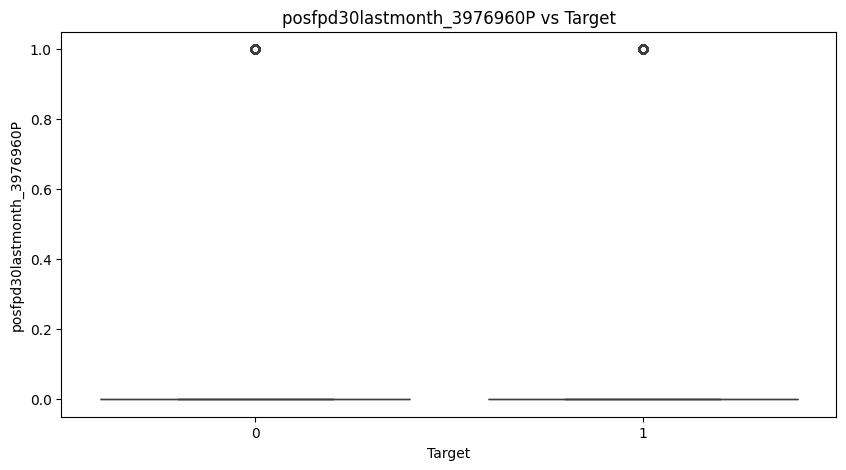

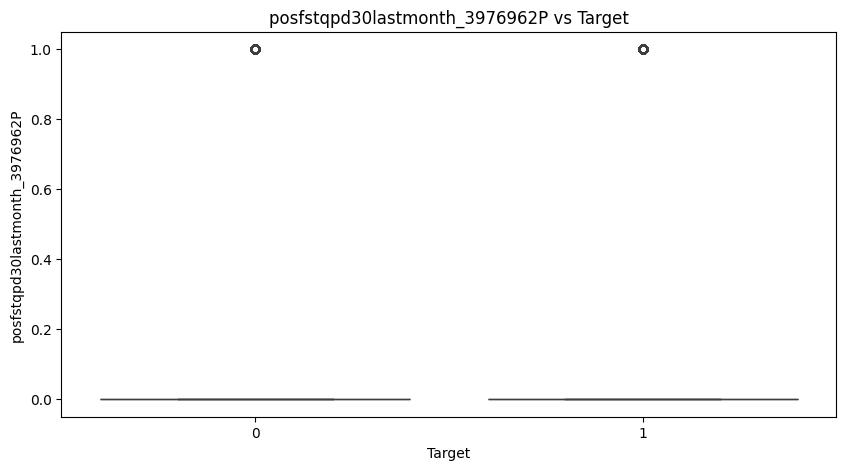

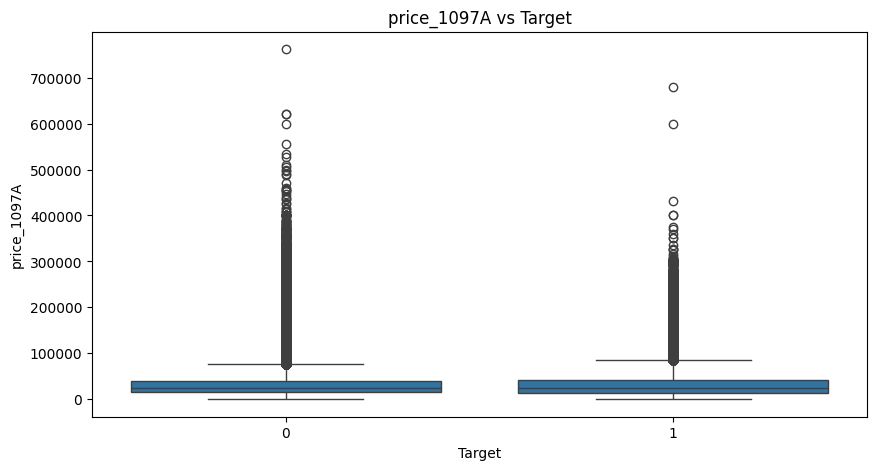

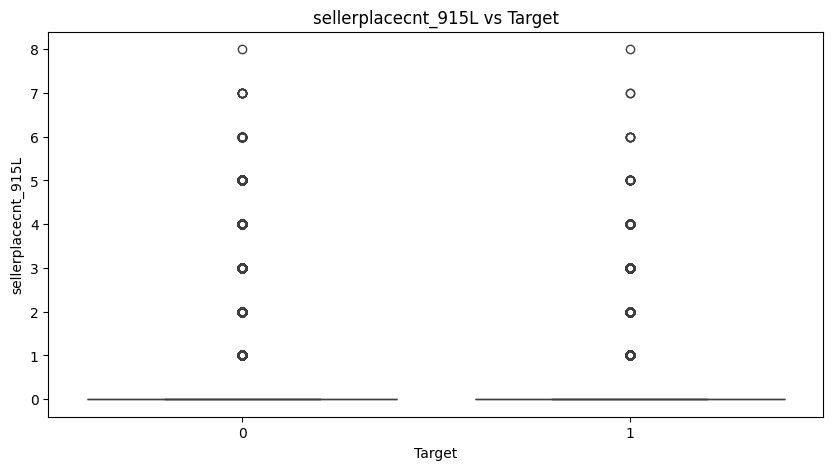

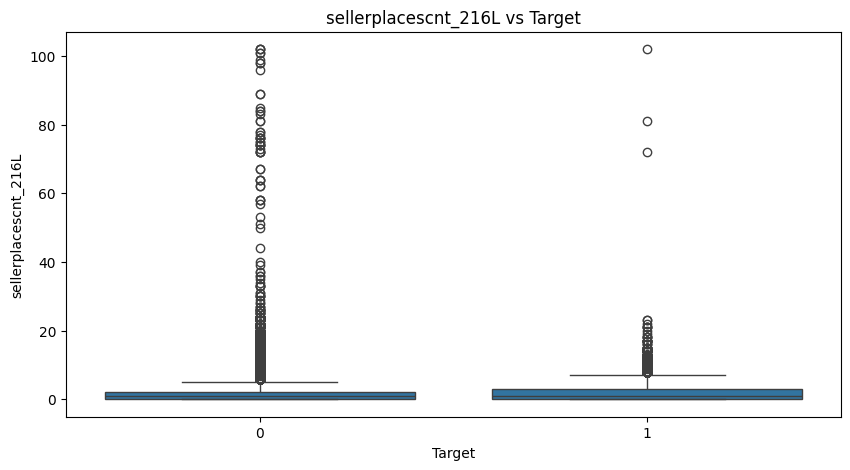

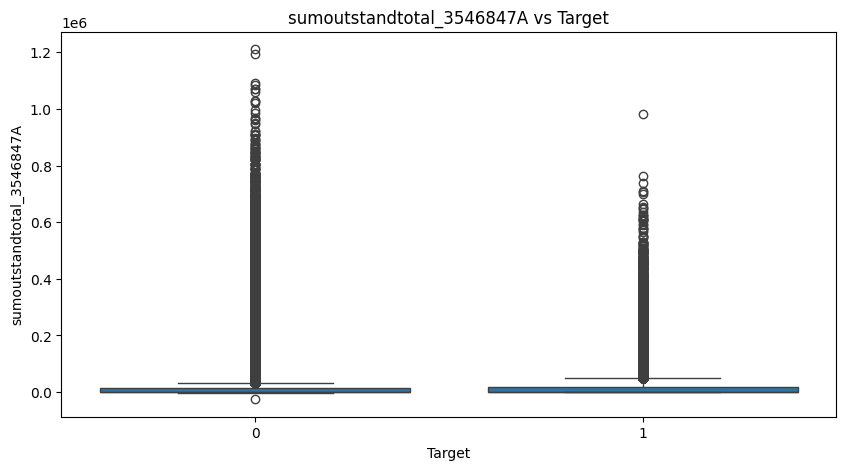

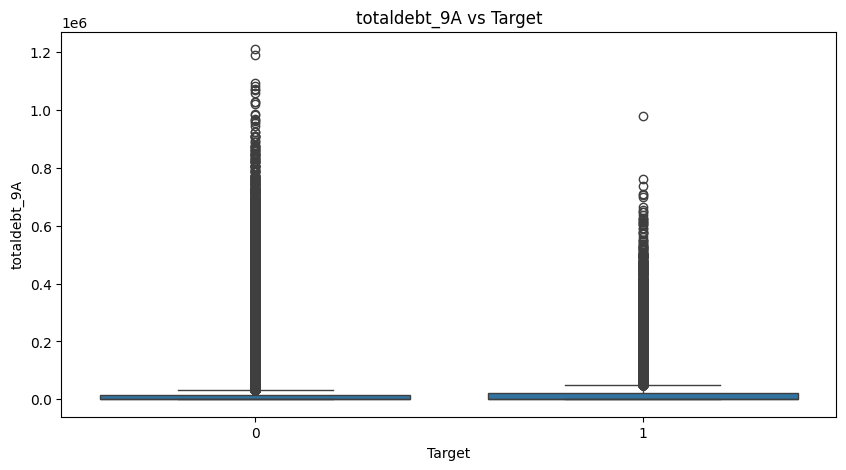

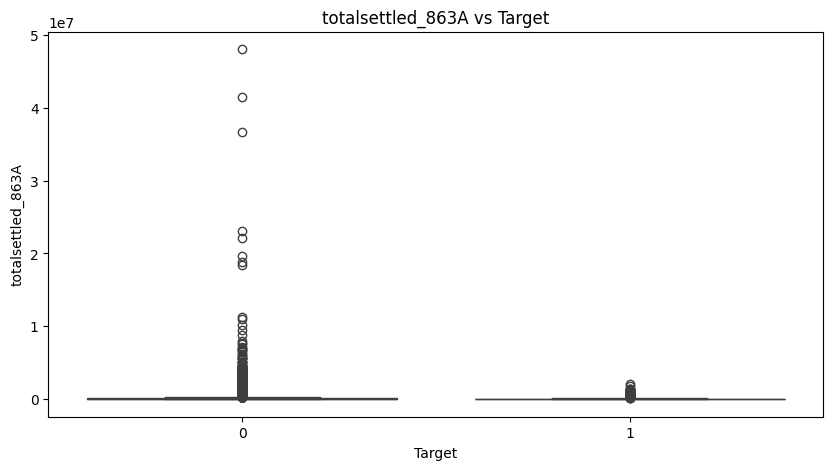

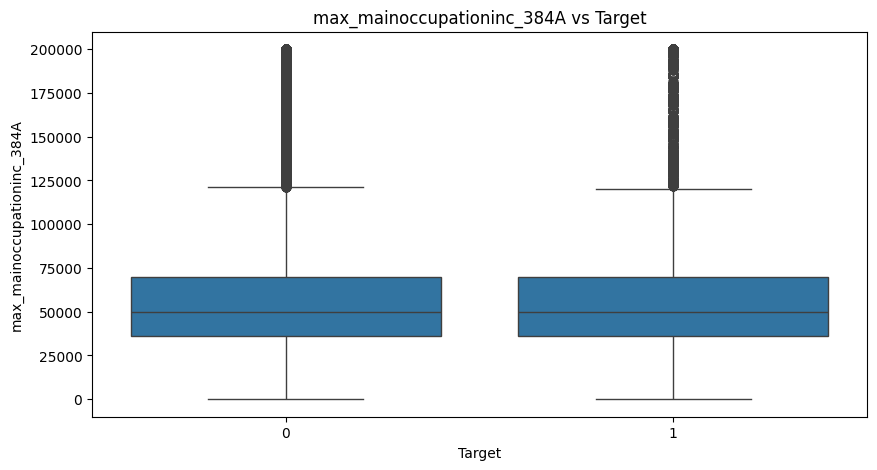

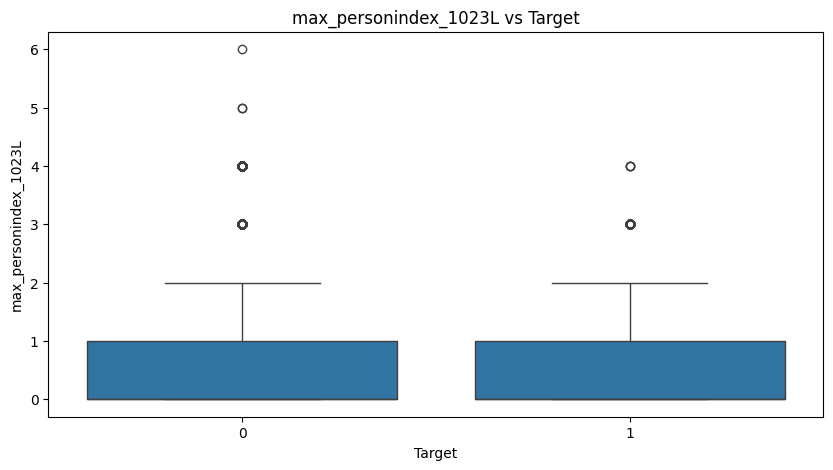

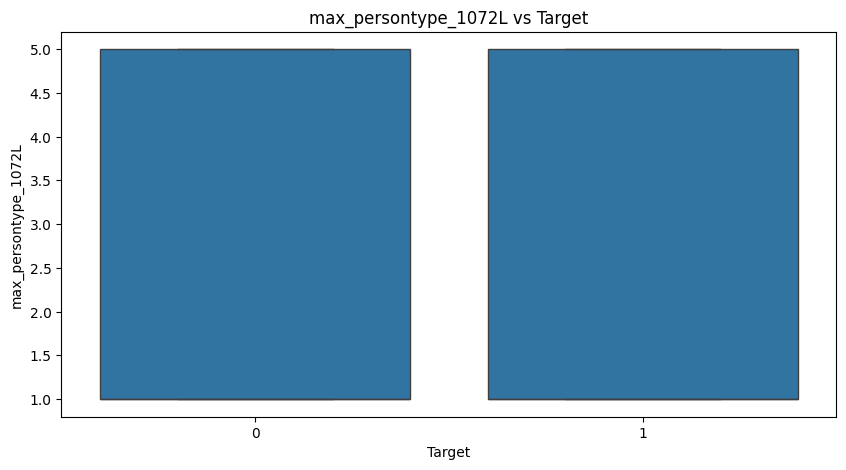

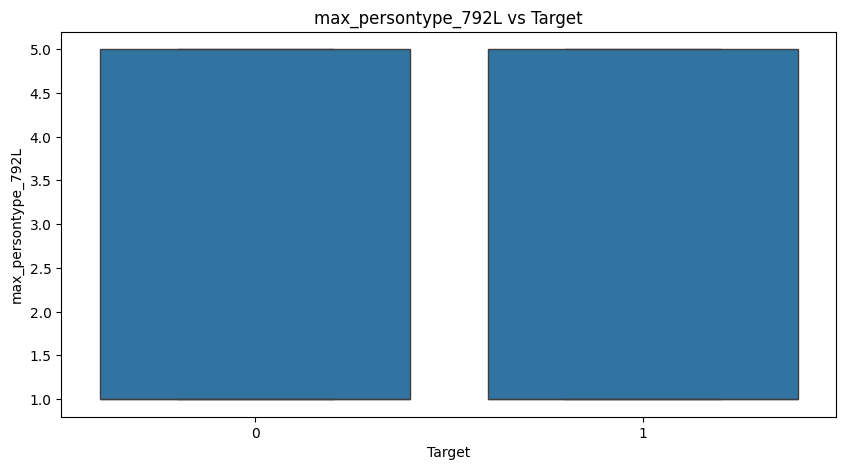

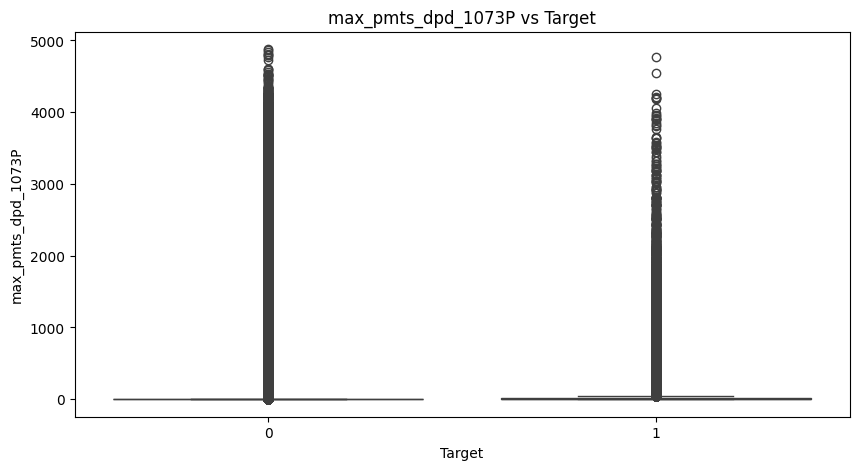

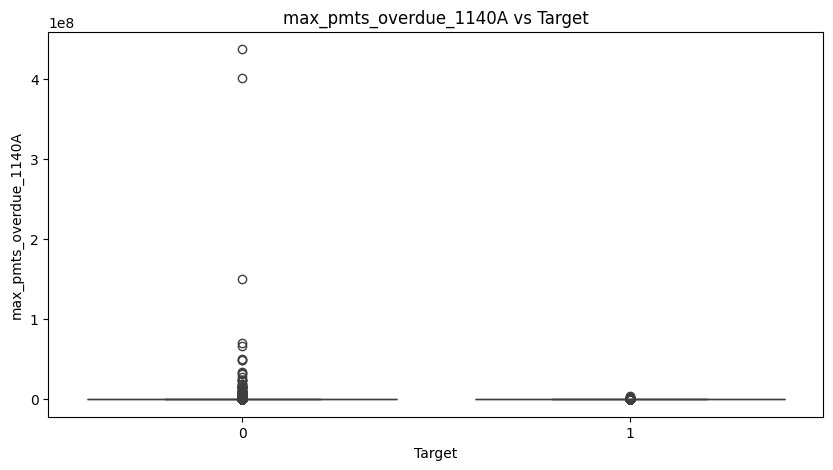

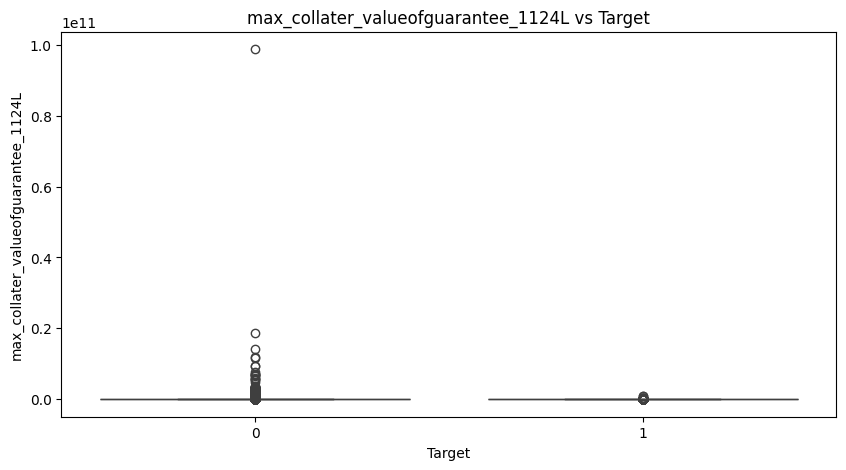

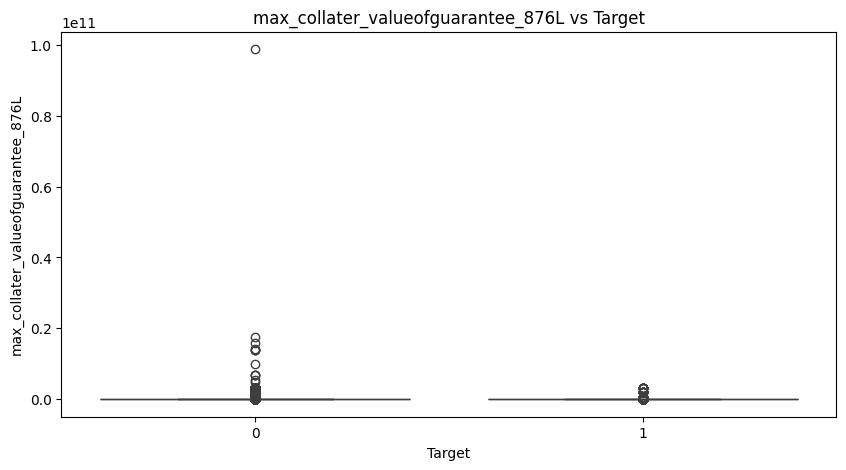

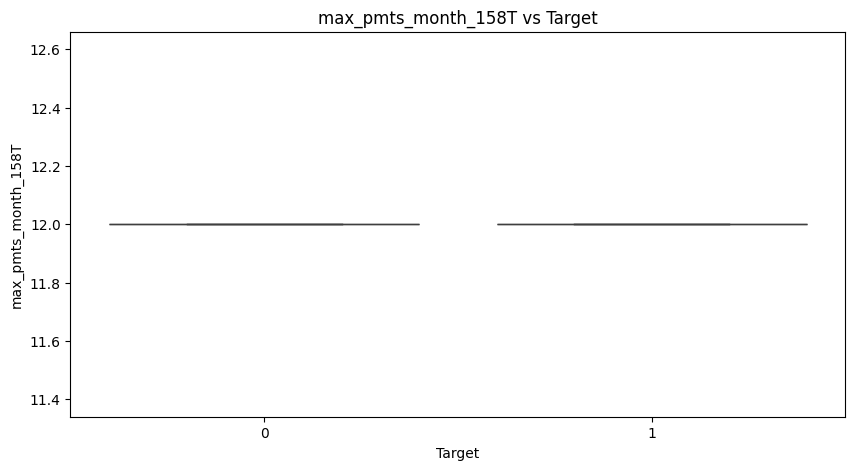

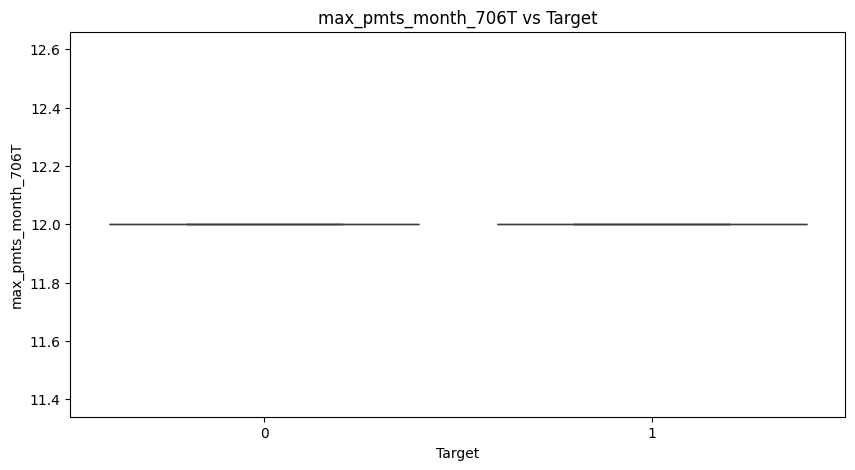

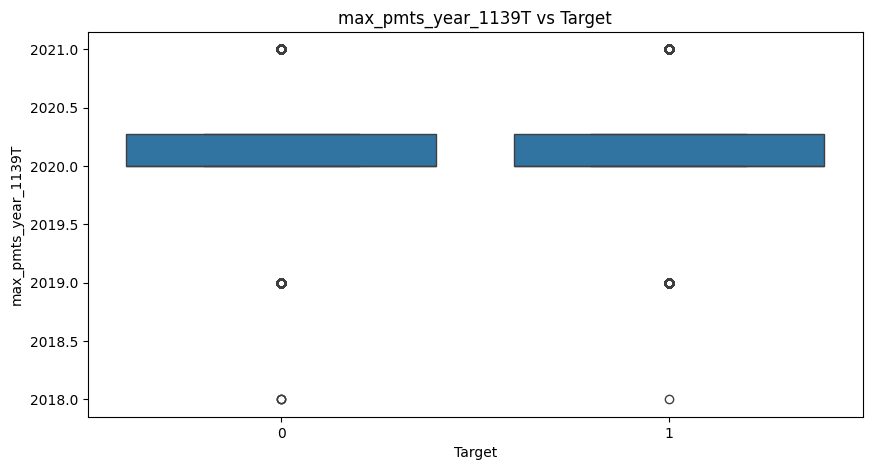

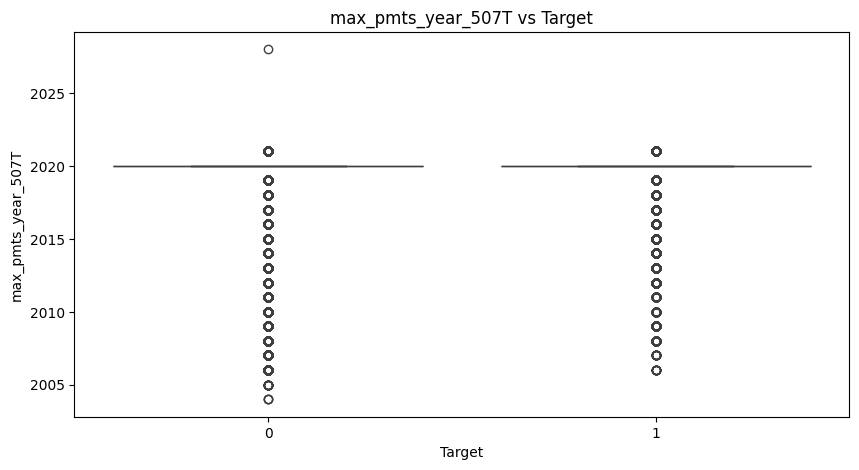

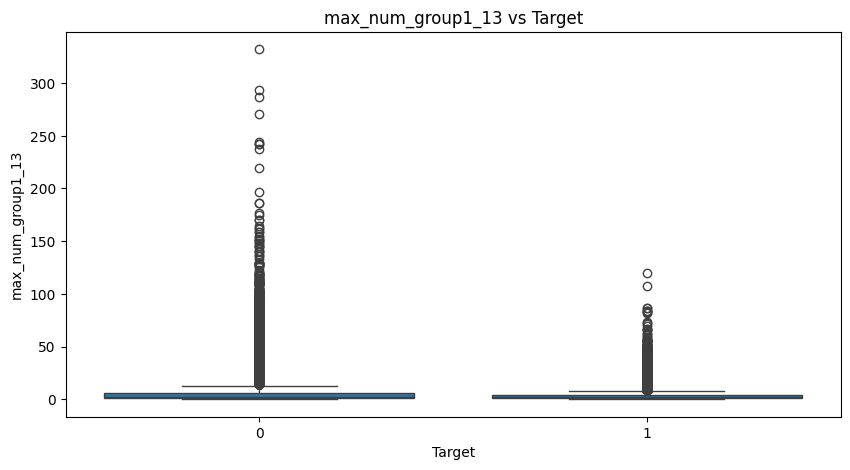

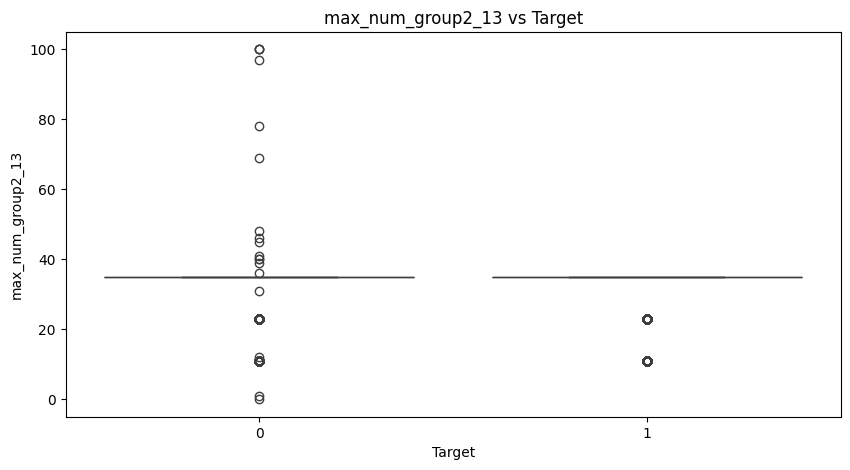

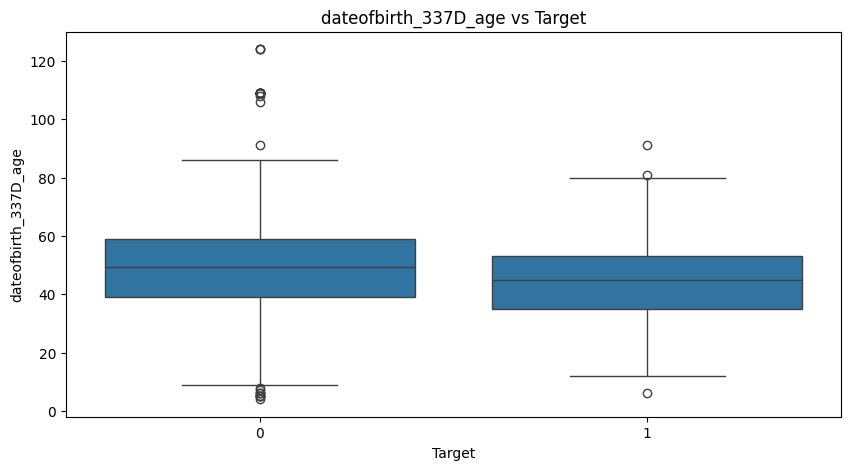

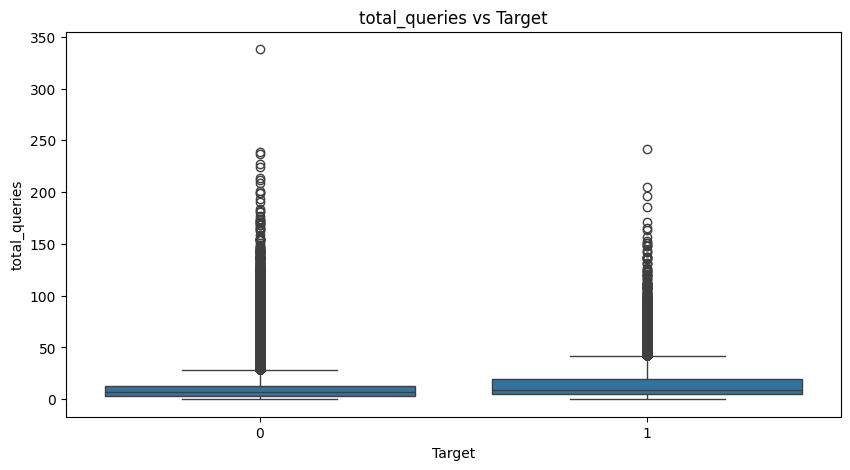

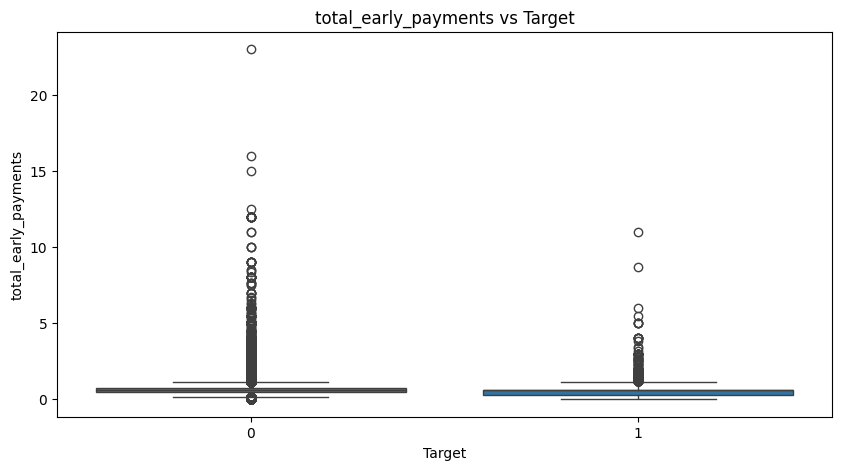

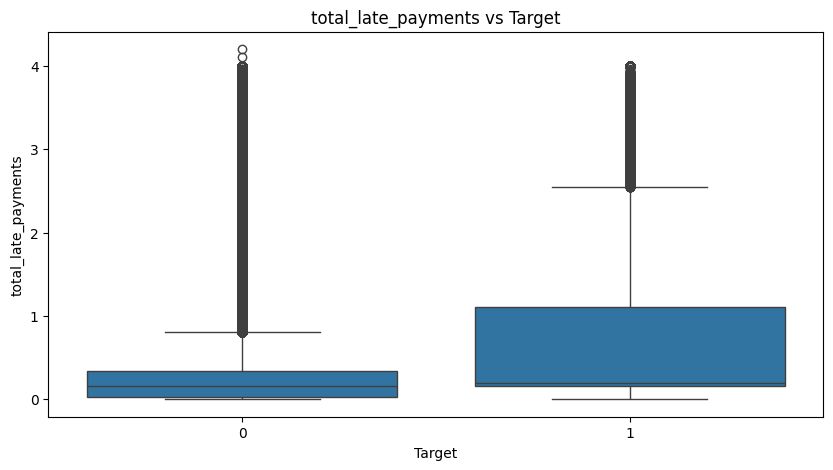

In [10]:
# List of numerical columns
numerical_columns = df_train_final.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns.remove('target')  # Remove the target column from the numerical columns list

# Plot box plots for numerical columns
for col in numerical_columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='target', y=col, data=df_train_final)
    plt.title(f"{col} vs Target")
    plt.xlabel('Target')
    plt.ylabel(col)
    plt.show()

## 3.3 Correlation Matrix

C:\Users\Darren Chang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Darren Chang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


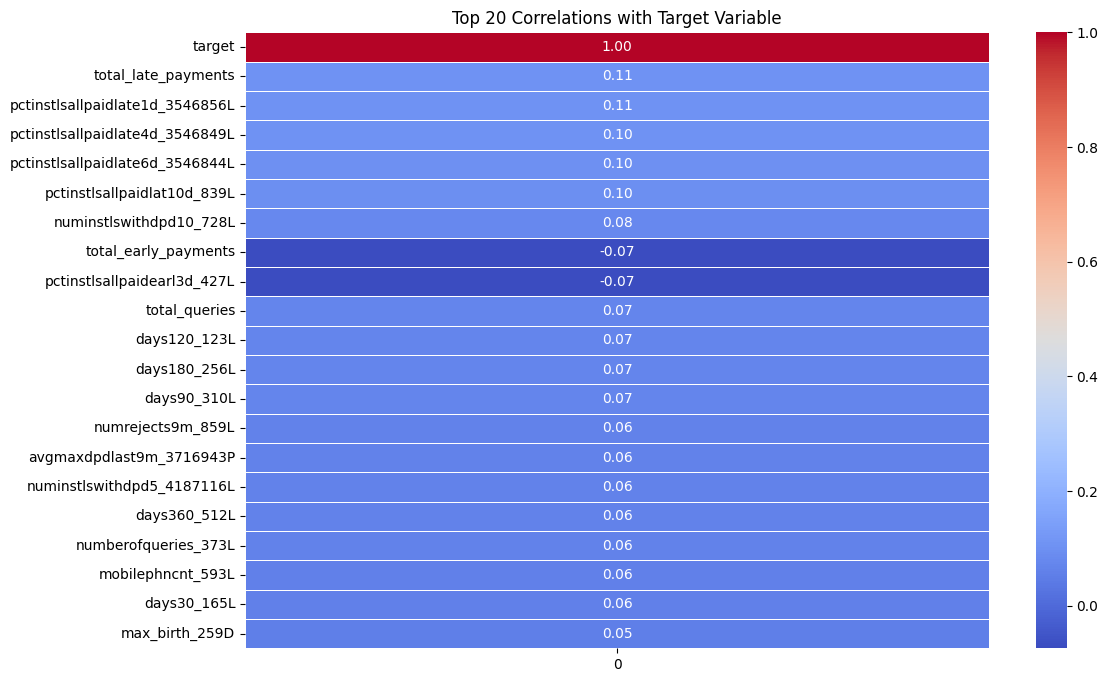

target                             1.000000
total_late_payments                0.105550
pctinstlsallpaidlate1d_3546856L    0.105333
pctinstlsallpaidlate4d_3546849L    0.102369
pctinstlsallpaidlate6d_3546844L    0.099254
pctinstlsallpaidlat10d_839L        0.095258
numinstlswithdpd10_728L            0.077157
total_early_payments              -0.074189
pctinstlsallpaidearl3d_427L       -0.074189
total_queries                      0.071302
days120_123L                       0.069841
days180_256L                       0.069556
days90_310L                        0.068630
numrejects9m_859L                  0.064094
avgmaxdpdlast9m_3716943P           0.062550
numinstlswithdpd5_4187116L         0.061295
days360_512L                       0.060717
numberofqueries_373L               0.060717
mobilephncnt_593L                  0.058783
days30_165L                        0.058096
max_birth_259D                     0.054223
dtype: float64


In [11]:
def calculate_correlation(df, target_column):
    # Ensure the target column is numeric
    if not pd.api.types.is_numeric_dtype(df[target_column]):
        raise ValueError(f"The target column '{target_column}' is not numeric.")

    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])

    # Calculate correlation matrix with respect to the target variable
    corr_with_target = numeric_df.corrwith(df[target_column])

    # Sort correlations in descending order and filter the top 20
    sorted_corr = corr_with_target.abs().sort_values(ascending=False).head(21)
    top_corr = corr_with_target[sorted_corr.index]

    # Plot heatmap of the top 20 correlations with the target variable
    plt.figure(figsize=(12, 8))
    sns.heatmap(top_corr.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Top 20 Correlations with Target Variable')
    plt.show()

    # Return top 20 correlations with target
    return top_corr

# Example usage
correlation_with_target = calculate_correlation(df_train_final, 'target')
print(correlation_with_target)

# 4. Model Building

## 4.1 Feature Engineering: Enhancing Data Insights Through Attribute Creation After Exploratory Data Analysis

In [12]:
# Late payment columns
late_payment_cols = [
    "pctinstlsallpaidlat10d_839L",
    "pctinstlsallpaidlate1d_3546856L",
    "pctinstlsallpaidlate4d_3546849L",
    "pctinstlsallpaidlate6d_3546844L"
]

# Calculate the average late payment percentage for df_train_final
df_train_final['avg_late_payment_percentage'] = df_train_final[late_payment_cols].mean(axis=1)

# Check if the avg_late_payment_percentage feature is included in training data
if 'avg_late_payment_percentage' in df_train_final.columns:
    print("avg_late_payment_percentage feature is included in training data.")
else:
    print("avg_late_payment_percentage feature is not included in training data.")

print("train data shape:\t", df_train_final.shape)

# Calculate the average late payment percentage for df_test_final
df_test_final['avg_late_payment_percentage'] = df_test_final[late_payment_cols].mean(axis=1)

# Check if the avg_late_payment_percentage feature is included in test data
if 'avg_late_payment_percentage' in df_test_final.columns:
    print("avg_late_payment_percentage feature is included in test data.")
else:
    print("avg_late_payment_percentage feature is not included in test data.")

print("test data shape:\t", df_test_final.shape)

avg_late_payment_percentage feature is included in training data.
train data shape:	 (1526659, 178)
avg_late_payment_percentage feature is included in test data.
test data shape:	 (10, 177)


## 4.2 Building of model LightLGB

In [13]:

    
# Define your data and models
X = df_train_final.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train_final["target"]
weeks = df_train_final["WEEK_NUM"]

# Define cross-validation strategy
cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

# Define LGBM parameters
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "colsample_bytree": 0.8, 
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "class_weight": "balanced",
}

# Train LGBM models
fitted_models = []
for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
    )

    fitted_models.append(model)

# Define VotingModel class
class VotingModel:
    def __init__(self, models):
        self.models = models
    
    def predict_proba(self, X):
        # Average the probabilities predicted by each model
        probas = [model.predict_proba(X) for model in self.models]
        avg_proba = np.mean(probas, axis=0)
        return avg_proba

# Instantiate the voting model
model = VotingModel(fitted_models)




Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.814428
[200]	valid_0's auc: 0.816287
Early stopping, best iteration is:
[154]	valid_0's auc: 0.817143
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.817065
[200]	valid_0's auc: 0.818704
Early stopping, best iteration is:
[160]	valid_0's auc: 0.819423
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.817942
[200]	valid_0's auc: 0.820486
Early stopping, best iteration is:
[178]	valid_0's auc: 0.82084
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.818147
[200]	valid_0's auc: 0.82055
Early stopping, best iteration is:
[153]	valid_0's auc: 0.821259
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.812409
[200]	valid_0's auc: 0.815721
Early stopping, best iteration is:
[167]	valid_0's auc: 0.816018


## 4.3 The important attributes for increasing the performance of the model

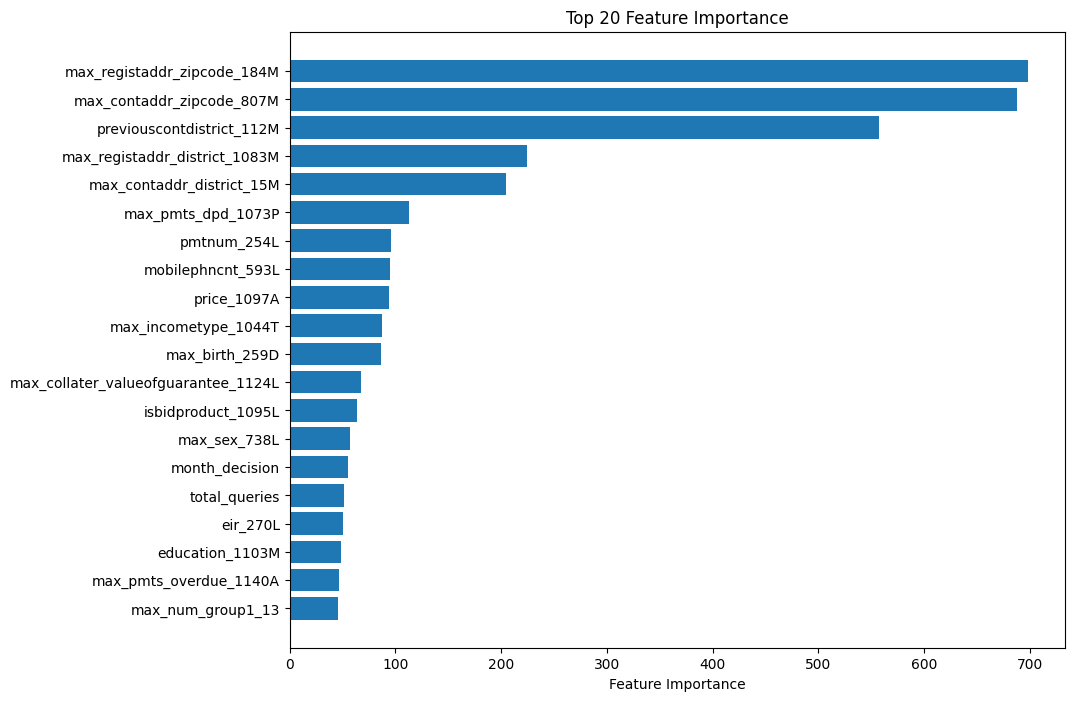

In [14]:
# Calculate and plot feature importance for the VotingModel
def calculate_feature_importance(models):
    # Aggregate feature importances from all models
    feature_importance = np.zeros(models[0].feature_importances_.shape)
    for model in models:
        feature_importance += model.feature_importances_

    # Normalize feature importance scores
    feature_importance /= len(models)

    return feature_importance

def plot_importance(importance, features, top_n=20):
    # Sort feature importance scores
    sorted_idx = np.argsort(importance)[::-1]
    sorted_importance = importance[sorted_idx]
    sorted_features = features[sorted_idx]

    # Plot top N features
    plt.figure(figsize=(10, 8))
    plt.barh(range(top_n), sorted_importance[:top_n], align='center')
    plt.yticks(np.arange(top_n), sorted_features[:top_n])
    plt.xlabel('Feature Importance')
    plt.title('Top {} Feature Importance'.format(top_n))
    plt.gca().invert_yaxis()
    plt.show()

# Get feature names
feature_names = X.columns

# Calculate feature importance
feature_importance = calculate_feature_importance(fitted_models)

# Plot feature importance
plot_importance(feature_importance, feature_names)

# 5. Model Evaluation and Validation

## 5.1 Calibration Curve

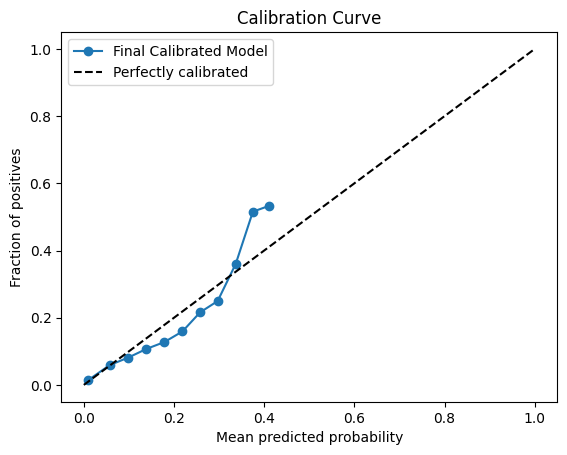

In [15]:
# Calibrate models
calibrated_models = []
for model in fitted_models:
    calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
    calibrated_model.fit(X_train, y_train)
    calibrated_models.append(calibrated_model)

# Select the final calibrated model (the last one in the list)
final_calibrated_model = calibrated_models[-1]
# Compute probabilities using the final calibrated model
prob_pos_final = final_calibrated_model.predict_proba(X_valid)[:, 1]
# Compute calibration curve for the final model
fraction_of_positives, mean_predicted_value = calibration_curve(y_valid, prob_pos_final, n_bins=25)
# Plot the calibration curve for the final model
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Final Calibrated Model')
# Plot the reference line (perfect calibration)
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
# Set plot labels and legend
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend(loc='best')
# Show plot
plt.show()



## 5.1 Target In Training Dataframe

In [ ]:
column_name = 'target'  
# Count the occurrences of '0' and '1' in the column
counts = df_train_final[column_name].value_counts()
print(f"Count of '0': {counts[0]}")
print(f"Count of '1': {counts[1]}") 

## 5.2 Stability Metric

In [16]:
# Predict probabilities for the training set
y_pred_train = pd.Series(model.predict_proba(X)[:, 1], index=X.index)

# Function to calculate the Gini coefficient
def gini(actual, pred):
    assert len(actual) == len(pred)
    all_data = np.c_[actual, pred, np.arange(len(actual))]
    all_data = all_data[np.lexsort((all_data[:, 2], -1 * all_data[:, 1]))]
    total_losses = all_data[:, 0].sum()
    gini_sum = all_data[:, 0].cumsum().sum() / total_losses

    gini_sum -= (len(actual) + 1) / 2.
    return gini_sum / len(actual)

# Function to calculate the normalized Gini coefficient
def normalized_gini(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

# Function to calculate weekly Gini coefficients
def calculate_weekly_gini(df_train_f, y_pred_train):
    weekly_gini = []
    for week in df_train_f["WEEK_NUM"].unique():
        week_data = df_train_f[df_train_f["WEEK_NUM"] == week]
        actual = week_data["target"]
        pred = y_pred_train.loc[week_data.index]
        weekly_gini.append(normalized_gini(actual, pred))
    return weekly_gini

# Calculate weekly Gini scores
weekly_gini_scores = calculate_weekly_gini(df_train_final, y_pred_train)

# Fit linear regression to the weekly Gini scores
weeks = df_train_final["WEEK_NUM"].unique()
slope, intercept, r_value, p_value, std_err = linregress(weeks, weekly_gini_scores)

# Determine the falling rate, ensuring it is non-positive
falling_rate = min(0, slope)

# Predict Gini scores using the linear regression model
predicted_gini_scores = intercept + slope * np.array(weeks)

# Calculate residuals and their standard deviation
residuals = weekly_gini_scores - predicted_gini_scores
std_residuals = np.std(residuals)

# Calculate the mean of the weekly Gini scores
mean_gini = np.mean(weekly_gini_scores)

# Calculate the stability metric
stability_metric = mean_gini + 88.0 * falling_rate - 0.5 * std_residuals

# Print the stability metric
print(f'Stability Metric: {stability_metric}')


Stability Metric: 0.6910086129130119


## 5.3 Score for the prediction

In [18]:
# Assuming df_test_final is already defined and model is trained
X_test = df_test_final.drop(columns=["WEEK_NUM"])
X_test = X_test.set_index("case_id")

# Predict the probabilities for the positive class (class 1)
y_pred = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

# Load the sample submission file
df_subm = pd.read_csv("/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv")
df_subm = df_subm.set_index("case_id")

# Assign the predicted probabilities to the score column
df_subm["score"] = y_pred

# Print a random sample of 10 rows from the DataFrame with scores
print(df_subm.sample(10))

# Save the DataFrame to a CSV file
df_subm.to_csv("/kaggle/working/submission.csv")



Check null:  False
            score
case_id          
57569    0.818910
57631    0.420149
57549    0.378390
57633    0.349557
57552    0.323035
